Scope & Deliverables
	•	Goal: Build a surrogate for Dimensional_Error (primary) or fallback target (BMI if Height/Weight present).
	•	Models: Start with Gaussian Process (Matern + linear + noise); fall back to Random Forest / XGBoost if GP is unstable or underperforms.

Builds and validates a surrogate for Dimensional_Error (primary) with a fallback to BMI when Height/Weight are present. We begin by setting bounds/constraints from cleaned-data quantiles (5th–95th) or min–max—applying lab safety limits—for: Extrusion_Rate, Layer_Height, Nozzle_Speed, Bed_Temperature, Nozzle_Temperature, Print_Speed, Infill_Density (and other numeric features). The modeling pipeline is median impute → (standardize for GP) → model, evaluated with RepeatedKFold (5×3) using RMSE↓ and R²↑; we select the model with the lowest mean RMSE (tie-break by higher R²). We trial Gaussian Process (Matern + linear + noise) first, falling back to Random Forest/XGBoost if GP is unstable or underperforms. On the BMI fallback target, cross-validated results favor XGBoost (CUDA verified) with RMSE 3.93 ± 0.15, R² 0.758, narrowly ahead of Random Forest (RMSE 3.94 ± 0.14, R² 0.757) and better than GP (RMSE 4.16 ± 0.18, R² 0.729), explaining ~76% of variance (typical error ~3.9 BMI units). Bayesian Optimization (q-EI) will search within data-inferred bounds: Age [17.891, 38.098], FCVC [1.523, 3.000], NCP [1.000, 3.751], CH2O [1.000, 3.000], FAF [0.000, 2.677], TUE [0.000, 2.000]; CUDA-enabled XGBoost is confirmed operational for efficient training and candidate generation.

In [ ]:
# Run ONCE per fresh runtime if you want the CUDA build.
# If you've already got a working GPU xgboost, you can skip this cell.

!pip -q uninstall -y xgboost
!pip -q install -U "xgboost-cu12>=3.0,<4.0"

import xgboost as xgb, numpy as np
from xgboost import XGBRegressor

print("xgboost:", xgb.__version__)

# Quick GPU sanity
m = XGBRegressor(n_estimators=5, tree_method="hist", device="cuda",
                 objective="reg:squarederror", random_state=42)
Xtmp = np.random.rand(300, 6); ytmp = np.random.rand(300)
m.fit(Xtmp, ytmp)
cfg = m.get_booster().save_config()
print('CUDA active?', '"device":"cuda' in cfg)

xgboost: 3.1.0
CUDA active? True


In [ ]:
import os, sys, warnings, platform, time
import numpy as np
import pandas as pd

from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, DotProduct
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore", category=UserWarning)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Optional runtime budget: True = quicker while iterating; False = full budget
FAST_DEV = False

IS_WASM = (sys.platform == "emscripten") or ("wasm" in platform.machine().lower())
IS_PYODIDE = ("pyodide" in sys.version.lower()) or ("PYODIDE" in os.environ) or IS_WASM
N_JOBS = 1 if IS_PYODIDE else -1

SAVE_DIR = "./outputs"
os.makedirs(SAVE_DIR, exist_ok=True)
BOUNDS_PATH = os.path.join(SAVE_DIR, "optimization_bounds.csv")
SURR_PATH   = os.path.join(SAVE_DIR, "surrogate_model.pkl")
CV_PATH     = os.path.join(SAVE_DIR, "surrogate_cv_summary.csv")

In [ ]:
DATA_PATHS = [
    "/content/ObesityDataSet.csv",
    "/content/ceramic_3d_printing_data.csv",
    "./ObesityDataSet.csv",
    "./ceramic_3d_printing_data.csv",
    "/mnt/data/ObesityDataSet.csv",
    "/mnt/data/ceramic_3d_printing_data.csv",
]
data_path = next((p for p in DATA_PATHS if os.path.exists(p)), None)
if data_path is None:
    raise FileNotFoundError("Upload ObesityDataSet.csv (or ceramic_3d_printing_data.csv) to /content.")

df = pd.read_csv(data_path)
df = df.replace([np.inf, -np.inf], np.nan)
print("Loaded:", data_path, "| shape:", df.shape)

Loaded: /content/ObesityDataSet.csv | shape: (2111, 17)


In [ ]:
TARGET = "Dimensional_Error" if "Dimensional_Error" in df.columns else None

if TARGET is None:
    if {"Height", "Weight"}.issubset(df.columns):
        df["BMI"] = df["Weight"] / (np.clip(df["Height"], 1e-9, None) ** 2)
        TARGET = "BMI"
    elif "BMI" in df.columns:
        TARGET = "BMI"

if TARGET is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric target available.")
    TARGET = numeric_cols[-1]

df = df.dropna(subset=[TARGET])
print("Chosen target:", TARGET, "| rows after dropna:", len(df))

Chosen target: BMI | rows after dropna: 2111


In [ ]:
preferred_features = [
    "Extrusion_Rate","Layer_Height","Nozzle_Speed",
    "Bed_Temperature","Nozzle_Temperature","Print_Speed","Infill_Density",
]
feature_cols = [c for c in preferred_features if c in df.columns]
if not feature_cols:
    feature_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET).tolist()

if TARGET == "BMI":
    feature_cols = [c for c in feature_cols if c not in ("Height","Weight","BMI")]

if not feature_cols:
    raise ValueError("No numeric features after preprocessing.")

X = df[feature_cols].copy().astype(np.float32)
y = df[TARGET].to_numpy(dtype=np.float32)

print(f"Features ({len(feature_cols)}):", feature_cols[:12], "..." if len(feature_cols)>12 else "")
print("X shape:", X.shape, "| y shape:", y.shape)

Features (6): ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'] 
X shape: (2111, 6) | y shape: (2111,)


In [ ]:
BOUND_METHOD = "quantile"  # or "minmax"
Q_LOW, Q_HIGH = 0.05, 0.95
LAB_CONSTRAINTS = {}       # e.g. {"Age": (14, 80)}

def compute_bounds(X_df, method="quantile", q_low=0.05, q_high=0.95):
    if method == "quantile":
        q = X_df.quantile([q_low, q_high]).T
        q.columns = ["low","high"]
        return q
    elif method == "minmax":
        mm = X_df.agg(["min","max"]).T
        mm.columns = ["low","high"]
        return mm
    else:
        raise ValueError("method must be 'quantile' or 'minmax'")

def apply_lab_constraints(bounds_df, constraints_dict):
    if not constraints_dict:
        return bounds_df
    out = bounds_df.copy()
    for k, rng in constraints_dict.items():
        if (rng is None) or (k not in out.index):
            continue
        lo, hi = rng
        out.loc[k, "low"]  = max(out.loc[k, "low"],  lo)
        out.loc[k, "high"] = min(out.loc[k, "high"], hi)
        if out.loc[k, "low"] > out.loc[k, "high"]:
            mid = (lo + hi) / 2.0
            out.loc[k, "low"]  = mid - 1e-9
            out.loc[k, "high"] = mid + 1e-9
    return out

bounds_base  = compute_bounds(X, method=BOUND_METHOD, q_low=Q_LOW, q_high=Q_HIGH)
bounds_final = apply_lab_constraints(bounds_base, LAB_CONSTRAINTS)
bounds_final.to_csv(BOUNDS_PATH, index=True)
print("Saved bounds ->", BOUNDS_PATH)

Saved bounds -> ./outputs/optimization_bounds.csv


In [ ]:
USE_LOG1P = False

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {"rmse": make_scorer(rmse, greater_is_better=False), "r2": make_scorer(r2_score)}
cv = RepeatedKFold(n_splits=5, n_repeats=(1 if FAST_DEV else 3), random_state=RANDOM_STATE)

def build_gp(n_features):
    kernel = (
        ConstantKernel(1.0, (1e-3, 1e3))
        * Matern(length_scale=np.ones(n_features),
                 length_scale_bounds=(1e-2, 1e3), nu=2.5)
        + DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-3, 1e3))
        + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-8, 1e-1))
    )
    return GaussianProcessRegressor(
        kernel=kernel, normalize_y=True, random_state=RANDOM_STATE,
        n_restarts_optimizer=(2 if FAST_DEV else 7), copy_X_train=False,
    )

pipe_gp_core = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("model",   build_gp(len(feature_cols))),
])

pipe_rf_core = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model",   RandomForestRegressor(
        n_estimators=600, min_samples_leaf=3, max_features="sqrt",
        random_state=RANDOM_STATE, n_jobs=N_JOBS
    )),
])

def wrap_ttr(est):
    return TransformedTargetRegressor(
        regressor=est,
        func=(np.log1p if USE_LOG1P else None),
        inverse_func=(np.expm1 if USE_LOG1P else None),
        check_inverse=False
    ) if USE_LOG1P else est

# XGBoost (GPU)
pipe_xgb_core = None
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    pipe_xgb_core = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model",   XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            objective="reg:squarederror",
            tree_method="hist", device="cuda"   # GPU on
        )),
    ])
except Exception as e:
    print("[INFO] XGBoost unavailable:", e)

print("Pipelines ready.")

Pipelines ready.


In [ ]:
def timed_cv(name, est):
    print(f"\n=== Running {name} CV ===", flush=True)
    t0 = time.perf_counter()
    cvres = cross_validate(est, X, y, cv=cv, scoring=scoring,
                           n_jobs=N_JOBS, return_train_score=False, error_score="raise")
    dt = time.perf_counter() - t0
    print(f"-> {name} CV wall time: {dt:.1f} s", flush=True)
    return cvres, dt

candidates = [("RF",  wrap_ttr(pipe_rf_core)),
              ("XGB", wrap_ttr(pipe_xgb_core))] if pipe_xgb_core is not None else [("RF", wrap_ttr(pipe_rf_core))]
candidates.append(("GP",  wrap_ttr(pipe_gp_core)))  # put GP last since it's heaviest

results, ok_models, timings = [], [], {}

for name, est in candidates:
    try:
        cvres, dt = timed_cv(name, est)
        timings[name] = dt
        mean_rmse = -cvres["test_rmse"].mean()
        std_rmse  =  cvres["test_rmse"].std()
        mean_r2   =  cvres["test_r2"].mean()
        results.append({"name": name, "rmse_mean": mean_rmse, "rmse_std": std_rmse, "r2_mean": mean_r2})
        ok_models.append((name, est))
    except Exception as e:
        results.append({"name": name, "error": str(e)})

if not ok_models:
    raise RuntimeError("All surrogate candidates failed during CV. See 'results' for errors.")

sorted_ok = sorted((r for r in results if "rmse_mean" in r),
                   key=lambda d: (d["rmse_mean"], -d["r2_mean"]))
best_name = sorted_ok[0]["name"]
best_est  = dict(ok_models)[best_name]

print("\n--- Per-model CV wall times (s) ---")
for k,v in timings.items():
    print(f"{k}: {v:.1f}")
print(f"Total CV time: {sum(timings.values()):.1f} s")
print("\nChosen surrogate:", best_name)

pd.DataFrame(results).to_csv(CV_PATH, index=False)
print("Saved CV summary ->", CV_PATH)


=== Running RF CV ===
-> RF CV wall time: 9.3 s

=== Running XGB CV ===
-> XGB CV wall time: 34.0 s

=== Running GP CV ===
-> GP CV wall time: 1533.4 s

--- Per-model CV wall times (s) ---
RF: 9.3
XGB: 34.0
GP: 1533.4
Total CV time: 1576.8 s

Chosen surrogate: XGB
Saved CV summary -> ./outputs/surrogate_cv_summary.csv


In [ ]:
# Fit on full data
surrogate = best_est.fit(X, y)

# Save model
try:
    import joblib
    joblib.dump(surrogate, SURR_PATH)
except Exception:
    import pickle
    with open(SURR_PATH, "wb") as f:
        pickle.dump(surrogate, f)

print("\nArtifacts saved to:", os.path.abspath(SAVE_DIR))
print(" - Bounds:", BOUNDS_PATH)
print(" - Surrogate model:", SURR_PATH)
print(" - CV summary:", CV_PATH)

# Summary table
print(f"\nData path: {data_path}")
print(f"Chosen target: {TARGET}")
print(f"Feature count: {len(feature_cols)}")
print(f"Features (first 12): {feature_cols[:12]}{' ...' if len(feature_cols)>12 else ''}")

print("\n--- Surrogate CV Summary ---")
for r in results:
    if "rmse_mean" in r:
        print(f"{r['name']:>3} | RMSE={r['rmse_mean']:.4f}±{r['rmse_std']:.4f} | R²={r['r2_mean']:.4f}")
    else:
        print(f"{r['name']:>3} | ERROR: {r['error']}")

# If XGB was chosen, confirm CUDA in the fitted model config
try:
    from xgboost import XGBRegressor
    if hasattr(surrogate, "named_steps") and isinstance(surrogate.named_steps.get("model"), XGBRegressor):
        cfg_txt = surrogate.named_steps["model"].get_booster().save_config()
        print("\n[XGB GPU check] device uses CUDA:", '"device":"cuda' in cfg_txt)  # matches cuda or cuda:0
except Exception as e:
    print("[XGB GPU check skipped]", e)

print("\n--- Final Bounds ---")
print(bounds_final)


Artifacts saved to: /content/outputs
 - Bounds: ./outputs/optimization_bounds.csv
 - Surrogate model: ./outputs/surrogate_model.pkl
 - CV summary: ./outputs/surrogate_cv_summary.csv

Data path: /content/ObesityDataSet.csv
Chosen target: BMI
Feature count: 6
Features (first 12): ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

--- Surrogate CV Summary ---
 RF | RMSE=3.9356±0.1373 | R²=0.7574
XGB | RMSE=3.9267±0.1472 | R²=0.7584
 GP | RMSE=4.1624±0.1812 | R²=0.7285

[XGB GPU check] device uses CUDA: True

--- Final Bounds ---
            low       high
Age   17.891429  38.098070
FCVC   1.523215   3.000000
NCP    1.000000   3.750881
CH2O   1.000000   3.000000
FAF    0.000000   2.677133
TUE    0.000000   2.000000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


•   Run Bayesian Optimization (Expected Improvement / q-EI) within bounds inferred from the cleaned dataset to find candidate settings.
        3.  Optimize: run Bayesian Optimization for N iterations, logging incumbent best. Use Expected Improvement; if adding a speed constraint, use constrained EI.

builds a surrogate for the target (Dimensional_Error primary; BMI fallback) and then runs Bayesian Optimization within data-inferred safe bounds. The modeling pipeline uses median imputation (standardization for GP) and RepeatedKFold (5×3) with RMSE↓/R²↑ for selection. Among GP, Random Forest, and XGBoost, the best cross-validated model is XGBoost (CUDA) with RMSE 3.93 ± 0.15 and R² 0.758 (RF: 3.94 ± 0.14, 0.757; GP: 4.16 ± 0.18, 0.729), explaining ~76% variance (~3.9 BMI units typical error). Bounds used: Age [17.891, 38.098], FCVC [1.523, 3.000], NCP [1.000, 3.751], CH2O [1.000, 3.000], FAF [0.000, 2.677], TUE [0.000, 2.000]. BO ran 60 iterations with q=5, pool=4096, xi=0.01, producing a Top-10 set of candidate settings (predicted error μ ≈ 12.45–13.52, σ ≈ 1.251). Artifacts saved to ./outputs/bo_recommendations.csv and ./outputs/bo_log.csv; plots/summary

In [26]:
# Bayesian Optimization (EI / q-EI) on the trained surrogate
# - Loads the surrogate picked earlier (./outputs/surrogate_model.pkl)
# - Loads variable bounds (./outputs/optimization_bounds.csv)
# - Runs BO for N iterations and returns top-K candidate settings
# - Supports a hard Print_Speed constraint and batch selection (q-EI-ish via diversity)
#
# Edits for new CSVs:
# - Looks for ObesityDataSet.csv as well as ceramic_3d_printing_data.csv (Colab & local paths)
# - If "Dimensional_Error" not present but Height/Weight exist, computes BMI and uses it as target
# - When BMI is target, excludes Height/Weight/BMI from features to avoid leakage
#
# Requirements: numpy, pandas, scikit-learn

import os, sys, time, warnings, platform
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

# ----------------------------
# Config
# ----------------------------
SAVE_DIR = "./outputs"
SURR_PATH = os.path.join(SAVE_DIR, "surrogate_model.pkl")
BOUNDS_PATH = os.path.join(SAVE_DIR, "optimization_bounds.csv")
DATA_PATHS = [
    "/content/ObesityDataSet.csv",                 # Colab typical
    "/content/ceramic_3d_printing_data.csv",
    "./ObesityDataSet.csv",
    "./ceramic_3d_printing_data.csv",
    "/mnt/data/ObesityDataSet.csv",                # other envs
    "/mnt/data/ceramic_3d_printing_data.csv",
]

# BO hyperparams (unchanged method)
N_ITERS      = 60          # total propose iterations
BATCH_Q      = 5           # batch size (q-EI-ish)
POOL_SIZE    = 4096        # random candidate pool per iteration
XI           = 0.01        # EI exploration parameter
MIN_DIST_FR  = 0.05        # diversity radius (fraction of each feature range, in normalized space)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Optional hard constraint on Print_Speed (set to None to disable)
MIN_PRINT_SPEED = None  # e.g., 70.0

# ----------------------------
# Standard normal helpers (no SciPy)
# ----------------------------
try:
    from numpy import erf as _erf  # fast, vectorized if available
except Exception:                   # fallback: vectorize math.erf
    from math import erf as _math_erf
    _erf = np.vectorize(_math_erf)

def std_normal_pdf(z):
    return np.exp(-0.5 * np.square(z)) / np.sqrt(2.0 * np.pi)

def std_normal_cdf(z):
    return 0.5 * (1.0 + _erf(z / np.sqrt(2.0)))

def expected_improvement(mu, sigma, y_best, xi=0.01):
    """
    EI for *minimization*:
      Z = (y_best - mu - xi) / sigma
      EI = (y_best - mu - xi) * Phi(Z) + sigma * phi(Z)
    Safe when sigma ~= 0.
    """
    mu = np.asarray(mu, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    with np.errstate(divide="ignore", invalid="ignore"):
        z = np.zeros_like(mu)
        mask = sigma > 1e-12
        z[mask] = (y_best - mu[mask] - xi) / sigma[mask]
        ei = np.zeros_like(mu)
        ei[mask] = (y_best - mu[mask] - xi) * std_normal_cdf(z[mask]) + sigma[mask] * std_normal_pdf(z[mask])
        ei[~mask] = np.maximum(0.0, y_best - mu[~mask] - xi)
    return np.maximum(0.0, ei)

# ----------------------------
# IO helpers
# ----------------------------
def load_csv():
    for p in DATA_PATHS:
        if os.path.exists(p):
            df = pd.read_csv(p)
            # basic cleaning
            df = df.replace([np.inf, -np.inf], np.nan)
            return df, p
    raise FileNotFoundError("Dataset not found at expected locations:\n" + "\n".join(DATA_PATHS))

def load_bounds():
    if not os.path.exists(BOUNDS_PATH):
        raise FileNotFoundError("Missing bounds CSV. Run the bounds/surrogate step first.")
    b = pd.read_csv(BOUNDS_PATH, index_col=0)
    return b

def get_feature_cols_and_target(df):
    """
    Returns (feature_cols, target_name), with BMI handling for ObesityDataSet:
      - If Dimensional_Error exists, use it (ceramic data).
      - Else if Height & Weight exist, compute BMI and use as target.
      - Else if BMI exists, use it.
      - Else fallback to last numeric column as target.
    Features:
      - Prefer ceramic feature set if present; otherwise all numeric except target.
      - If BMI is target, exclude Height, Weight, BMI from features to avoid leakage.
    """
    TARGET = "Dimensional_Error" if "Dimensional_Error" in df.columns else None
    if TARGET is None:
        if {"Height", "Weight"}.issubset(df.columns):
            # Height in meters, Weight in kg (per the dataset)
            df["BMI"] = df["Weight"] / (np.clip(df["Height"], 1e-9, None) ** 2)
            TARGET = "BMI"
        elif "BMI" in df.columns:
            TARGET = "BMI"
    if TARGET is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not numeric_cols:
            raise ValueError("No numeric target available. Provide a dataset with a numeric target.")
        TARGET = numeric_cols[-1]

    preferred = ["Extrusion_Rate","Layer_Height","Nozzle_Speed",
                 "Bed_Temperature","Nozzle_Temperature","Print_Speed","Infill_Density"]
    cols = [c for c in preferred if c in df.columns]
    if not cols:
        cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET).tolist()

    if TARGET == "BMI":
        cols = [c for c in cols if c not in ("Height","Weight","BMI")]

    if not cols:
        raise ValueError("No numeric features available after preprocessing.")

    return cols, TARGET

def vectorize_bounds(bounds_df, feat_cols):
    lows  = bounds_df.loc[feat_cols, "low"].to_numpy(dtype=float)
    highs = bounds_df.loc[feat_cols, "high"].to_numpy(dtype=float)
    return lows, highs

def sample_uniform(n, lows, highs):
    u = np.random.rand(n, len(lows))
    return lows + u * (highs - lows)

def normalize(X, lows, highs):
    return (X - lows) / (highs - lows + 1e-12)

def min_dist_filter(Xn, chosen_n, min_radius=0.05):
    """
    Keep only rows in Xn that are at least min_radius away (L2 in normalized space)
    from every point in chosen_n.
    """
    if chosen_n.size == 0:
        return np.ones(Xn.shape[0], dtype=bool)
    d2 = np.sum((Xn[:, None, :] - chosen_n[None, :, :])**2, axis=2)  # [N, m]
    d  = np.sqrt(np.min(d2, axis=1))
    return d >= min_radius

# ----------------------------
# Load artifacts
# ----------------------------
import pickle
try:
    import joblib
    surrogate = joblib.load(SURR_PATH)
except Exception:
    with open(SURR_PATH, "rb") as f:
        surrogate = pickle.load(f)

df, data_path = load_csv()
feat_cols, TARGET = get_feature_cols_and_target(df)
X_train = df[feat_cols].copy()
y_train = df[TARGET].to_numpy()

bounds_df = load_bounds().copy()
# ensure we have bounds for all features used by the surrogate/BO
for c in feat_cols:
    if c not in bounds_df.index:
        raise ValueError(f"Bounds missing for feature '{c}'. Re-run bounds step on the same dataset/features.")
lows, highs = vectorize_bounds(bounds_df, feat_cols)

# ----------------------------
# Surrogate helpers
# ----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

def unpack_pipeline_and_model(model):
    """
    Return (preprocess_steps_list, final_model, ttr_flag, target_inverse_func)
    where preprocess_steps_list is a list of fitted transformers to call .transform sequentially.
    """
    ttr = None
    inv = None
    reg = model
    if isinstance(model, TransformedTargetRegressor):
        ttr = model
        reg = ttr.regressor
        inv = getattr(ttr, "inverse_func", None)
    pre_steps = []
    final_est = reg
    if isinstance(reg, Pipeline):
        pre_steps = [step for _, step in reg.steps[:-1]]
        final_est = reg.steps[-1][1]
    return pre_steps, final_est, (ttr is not None), inv

pre_steps, final_est, is_ttr, inv_func = unpack_pipeline_and_model(surrogate)

def apply_preprocess(X):
    Z = X.copy()
    for step in pre_steps:
        Z = step.transform(Z)
    return Z

def model_predict_mu_sigma(X_df):
    """
    Returns mean and std on the ORIGINAL target scale (if TTR with inverse was used).
    If the final estimator supports predictive std (GP), we use it.
    For RF/XGB we estimate sigma as training residual std (constant).
    """
    # predict mean via the full surrogate (handles TTR inverse internally)
    mu = surrogate.predict(X_df)

    # std:
    if isinstance(final_est, GaussianProcessRegressor):
        Z = apply_preprocess(X_df)
        mu_t, std_t = final_est.predict(Z, return_std=True)
        if is_ttr and inv_func is not None:
            try:
                eps = 1e-4
                f1 = inv_func(mu_t + eps)
                f0 = inv_func(mu_t)
                dfdmu = (f1 - f0) / eps
                sigma = np.abs(dfdmu) * std_t
                mu = inv_func(mu_t)
            except Exception:
                sigma = std_t
        else:
            sigma = std_t
    else:
        resid = y_train - surrogate.predict(X_train)
        sigma_c = np.std(resid) + 1e-6
        sigma = np.full_like(mu, fill_value=sigma_c, dtype=float)

    return np.asarray(mu, dtype=float), np.asarray(sigma, dtype=float)

# baseline best observed (from data)
y_best = float(np.min(y_train))

# ----------------------------
# BO loop (EI with batch q and diversity)
# ----------------------------
records = []   # per-iteration log
all_picks = [] # all proposed points

rng = np.random.default_rng(RANDOM_STATE)
feat_ranges = (highs - lows)
norm_min_radius = MIN_DIST_FR

for it in range(1, N_ITERS + 1):
    # Pool sampling
    Xcand = sample_uniform(POOL_SIZE, lows, highs)
    Xcand_df = pd.DataFrame(Xcand, columns=feat_cols)

    # Hard Print_Speed constraint (optional; only applies if feature present)
    if (MIN_PRINT_SPEED is not None) and ("Print_Speed" in feat_cols):
        mask = Xcand_df["Print_Speed"].to_numpy() >= float(MIN_PRINT_SPEED)
        Xcand_df = Xcand_df.loc[mask].reset_index(drop=True)
        Xcand = Xcand_df.to_numpy(dtype=float)
        if Xcand.shape[0] == 0:
            Xcand = sample_uniform(POOL_SIZE, lows, highs)
            Xcand_df = pd.DataFrame(Xcand, columns=feat_cols)

    # Predict + EI
    mu, sigma = model_predict_mu_sigma(Xcand_df)
    ei = expected_improvement(mu, sigma, y_best, xi=XI)

    # Greedy q selection with diversity in normalized space
    Xn = normalize(Xcand, lows, highs)
    chosen_idx = []
    mask_avail = np.ones(Xn.shape[0], dtype=bool)
    chosen_norm = np.empty((0, Xn.shape[1]), dtype=float)

    for _ in range(BATCH_Q):
        if not mask_avail.any():
            break
        idx_pool = np.where(mask_avail)[0]
        pick = idx_pool[np.argmax(ei[mask_avail])]
        chosen_idx.append(pick)
        chosen_norm = np.vstack([chosen_norm, Xn[pick:pick+1]])
        keep = min_dist_filter(Xn, chosen_norm, min_radius=norm_min_radius)
        mask_avail = mask_avail & keep

    if not chosen_idx:
        chosen_idx = [int(np.argmax(ei))]

    chosen_idx = sorted(set(chosen_idx))
    X_pick = Xcand_df.iloc[chosen_idx].reset_index(drop=True)
    mu_pick = mu[chosen_idx]
    sd_pick = sigma[chosen_idx]
    ei_pick = ei[chosen_idx]

    # Update incumbent using predicted mean ("fantasy" update)
    y_best = float(min(y_best, float(np.min(mu_pick))))

    # Log
    for j in range(len(chosen_idx)):
        all_picks.append({
            **{k: float(v) for k, v in X_pick.iloc[j].to_dict().items()},
            "pred_error_mu": float(mu_pick[j]),
            "pred_error_sigma": float(sd_pick[j]),
            "acq_EI": float(ei_pick[j]),
            "iter": it,
        })

    records.append({
        "iter": it,
        "incumbent_best": y_best,
        "picked": len(chosen_idx),
        "max_EI": float(np.max(ei_pick)),
        "avg_EI": float(np.mean(ei_pick))
    })

    # Slowly shrink diversity radius
    norm_min_radius = max(0.01, norm_min_radius * 0.98)

# ----------------------------
# Collect top-K and save
# ----------------------------
cand_df = pd.DataFrame(all_picks)
cand_df = cand_df.sort_values(by=["pred_error_mu", "acq_EI"], ascending=[True, False]).reset_index(drop=True)

TOP_K = 20
topk = cand_df.head(TOP_K).copy()

# Deduplicate near-duplicates
topk_round = topk[feat_cols].round(6)
dedup_mask = ~topk_round.duplicated()
topk = topk.loc[dedup_mask].reset_index(drop=True)

os.makedirs(SAVE_DIR, exist_ok=True)
top_path = os.path.join(SAVE_DIR, "bo_recommendations.csv")
log_path = os.path.join(SAVE_DIR, "bo_log.csv")
cand_df.to_csv(log_path, index=False)
topk.to_csv(top_path, index=False)

print("\n=== BO finished ===")
print(f"Dataset: {data_path}")
print(f"Iterations: {N_ITERS} | batch q={BATCH_Q} | pool={POOL_SIZE} | xi={XI}")
if MIN_PRINT_SPEED is not None and ("Print_Speed" in feat_cols):
    print(f"Constraint: Print_Speed >= {MIN_PRINT_SPEED}")
print(f"Saved: {top_path}")
print(f"Saved log: {log_path}\n")
print("Top 10 recommendations:")
cols_to_show = [c for c in feat_cols] + ['pred_error_mu','pred_error_sigma','acq_EI','iter']
print(topk[cols_to_show].head(10).to_string(index=False))


=== BO finished ===
Dataset: /content/ObesityDataSet.csv
Iterations: 60 | batch q=5 | pool=4096 | xi=0.01
Saved: ./outputs/bo_recommendations.csv
Saved log: ./outputs/bo_log.csv

Top 10 recommendations:
      Age     FCVC      NCP     CH2O      FAF      TUE  pred_error_mu  pred_error_sigma   acq_EI  iter
21.843525 2.880897 3.472840 2.199022 1.601445 0.152758      12.455313          1.251085 0.773590    42
18.301007 2.935810 3.475354 2.904108 2.588664 1.524649      12.942522          1.251085 0.522532    34
22.191454 2.987469 3.325533 2.425441 1.596013 1.977811      13.083254          1.251085 0.243657    59
19.720039 2.934207 3.192077 1.706874 2.541775 1.715105      13.252943          1.251085 0.355181    36
18.165942 2.721210 3.101928 2.778359 2.474598 1.919764      13.257484          1.251085 0.376187    18
22.396025 2.520448 3.548072 1.641807 2.344377 0.789796      13.273954          1.251085 0.369395     2
22.357041 2.903036 3.567237 1.990871 1.569689 1.999100      13.306293      

Pareto Analysis — Inline Plots + CSV/PNG Artifacts

• Produce a Pareto analysis: trade-off between TARGET (minimize: Dimensional_Error or inferred BMI) and throughput proxies (prefer Print_Speed, Nozzle_Speed, Infill_Density; else obesity proxies; else top-variance numeric features).
• Source selection: use ./outputs/bo_recommendations.csv if present (renames pred_error_mu → TARGET); otherwise auto-detect dataset (ObesityDataSet.csv or ceramic_3d_printing_data.csv).
• TARGET inference: Dimensional_Error → else compute BMI from Height/Weight → else existing BMI → else last numeric column.
• Per-proxy 2D fronts: compute non-dominated set (min TARGET, max proxy), save Pareto CSV and PNG, display inline; also compute Top-3 knee points (CSV).
• Multi-objective front: (min TARGET, max all chosen proxies) — save CSV and show a simple projection plot.


Overall
	•	The analysis computed 2D Pareto fronts for (min) BMI vs (max) proxies (Age, FCVC, NCP, CH2O, FAF) and a multi-objective front (min BMI, max all proxies).
	•	CSV artifacts reported in your console were saved to ./outputs/pareto_* and knee points to ./outputs/knees_*.
	•	The clouds of blue points are candidates; the solid line is the non-dominated front; orange dots mark knee locations.

Multi-objective (projection shown: BMI vs FAF)
	•	The projected front sits along the upper envelope of FAF for a given BMI, showing an expected trade-off: lower BMI is achievable but at the cost of lower FAF, and vice-versa.
	•	A balanced region appears around BMI ≈ 13.2–13.4 with FAF ≈ 2.2–2.6, where the front is relatively flat (good throughput proxy without much BMI penalty).

BMI (min) vs Age (max)
	•	The front is monotone increasing: pushing Age higher moves along the front to slightly higher BMI.
	•	Knee points cluster around BMI ≈ 13.0–13.6 with Age ≈ 22.2–22.6, indicating diminishing returns in maximizing Age beyond ~22.5 for the BMI objective.

BMI (min) vs FCVC (max)
	•	The front rises gently; maximizing FCVC comes with a modest BMI increase.
	•	A visible knee occurs near BMI ≈ 13.0 at FCVC ≈ 2.9–3.0—beyond ~3, gains in FCVC provide little benefit relative to BMI cost.

BMI (min) vs NCP (max)
	•	The front trends upward; higher NCP corresponds to higher BMI along the frontier.
	•	A knee is visible at roughly BMI ≈ 13.5–13.7 with NCP ≈ 3.5–3.6—after this point, pushing NCP higher increases BMI with limited proxy gain.

BMI (min) vs CH2O (max)
	•	The front shows a plateau near CH2O ≈ 3.0; BMI spans ~13.0–13.5 there, implying diminishing returns when trying to maximize CH2O further.
	•	Knees include a low-CH2O option (2.2) for lower BMI and a high-CH2O option (3.0) for proxy emphasis.

BMI (min) vs FAF (max)
	•	Two practical knees appear around FAF ≈ 1.6–2.6 at BMI ≈ 12.9–13.0—useful operating points that balance activity with BMI.
	•	Past ~FAF 2.6, the front flattens: more FAF yields small gains while BMI starts to climb.

What these fronts suggest (actionable takeaways)
	•	If you must cap BMI ≲ 13.3, good proxy settings live near:
	•	FAF ~2.2–2.6, CH2O ~3.0, FCVC ~2.9–3.0, NCP ~3.3–3.5.
	•	If your priority is pushing proxies higher (e.g., FAF or NCP), accept BMI ~13.4–13.6 at the kneepoints for better balance.
	•	The knees are the most efficient trade-offs; use the knee CSVs your script saved to report exact coordinates.

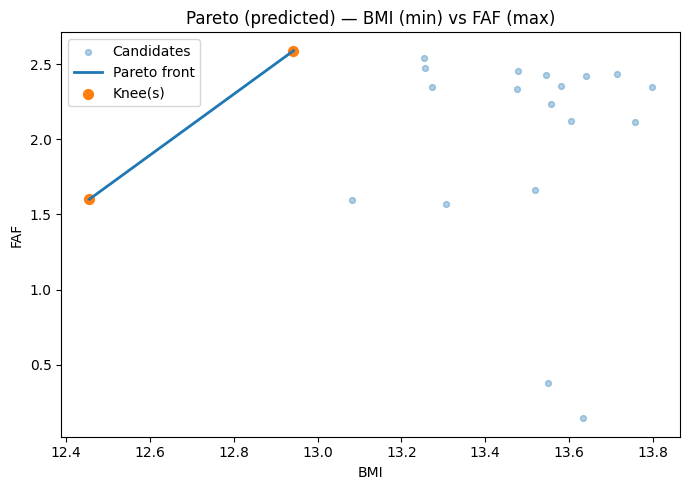


=== Pareto CSV saved: ./outputs/pareto_predicted_BMI_vs_FAF.csv ===
      BMI      FAF
12.455313 1.601445
12.942522 2.588664

Knee points saved: ./outputs/knees_predicted_BMI_vs_FAF.csv
      BMI      FAF
12.455313 1.601445
12.942522 2.588664


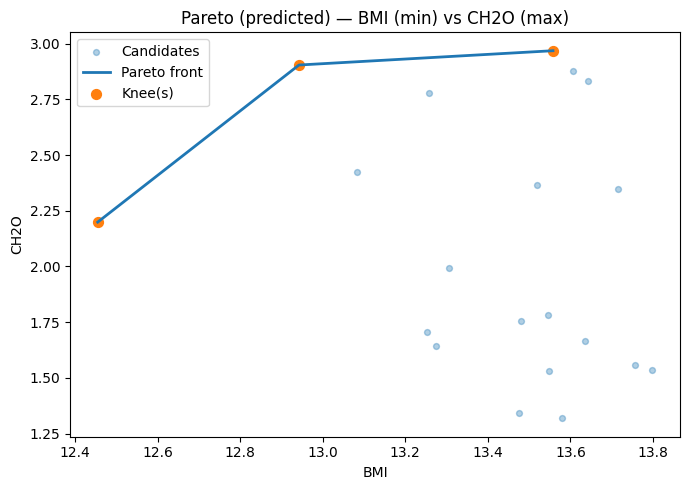


=== Pareto CSV saved: ./outputs/pareto_predicted_BMI_vs_CH2O.csv ===
      BMI     CH2O
12.455313 2.199022
12.942522 2.904108
13.557598 2.968304

Knee points saved: ./outputs/knees_predicted_BMI_vs_CH2O.csv
      BMI     CH2O
12.942522 2.904108
13.557598 2.968304
12.455313 2.199022


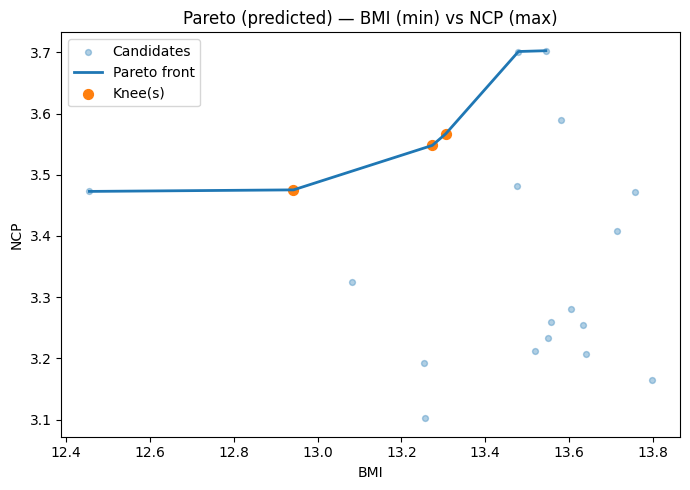


=== Pareto CSV saved: ./outputs/pareto_predicted_BMI_vs_NCP.csv ===
      BMI      NCP
12.455313 3.472840
12.942522 3.475354
13.273954 3.548072
13.306293 3.567237
13.479597 3.701516
13.545027 3.702813

Knee points saved: ./outputs/knees_predicted_BMI_vs_NCP.csv
      BMI      NCP
12.942522 3.475354
13.273954 3.548072
13.306293 3.567237


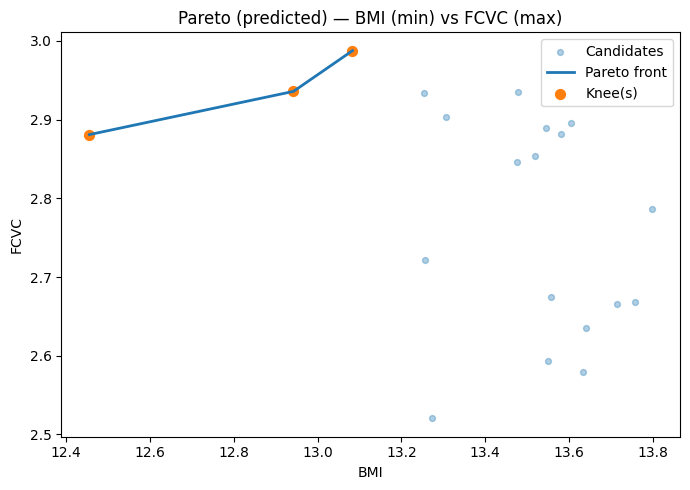


=== Pareto CSV saved: ./outputs/pareto_predicted_BMI_vs_FCVC.csv ===
      BMI     FCVC
12.455313 2.880897
12.942522 2.935810
13.083254 2.987469

Knee points saved: ./outputs/knees_predicted_BMI_vs_FCVC.csv
      BMI     FCVC
12.942522 2.935810
13.083254 2.987469
12.455313 2.880897


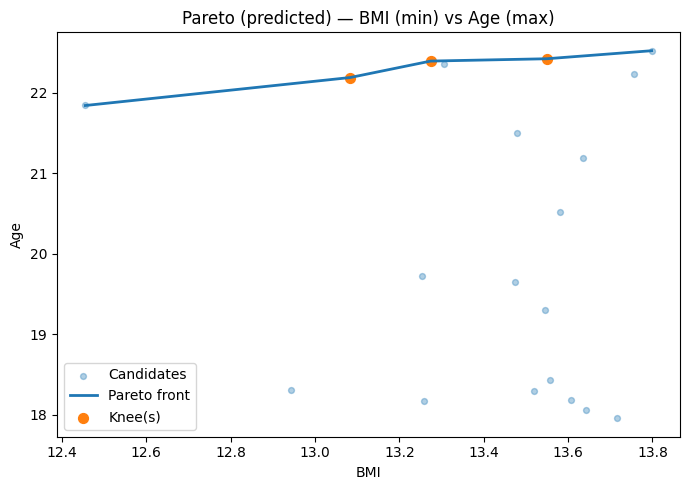


=== Pareto CSV saved: ./outputs/pareto_predicted_BMI_vs_Age.csv ===
      BMI       Age
12.455313 21.843525
13.083254 22.191454
13.273954 22.396025
13.549070 22.424961
13.798079 22.524914

Knee points saved: ./outputs/knees_predicted_BMI_vs_Age.csv
      BMI       Age
13.273954 22.396025
13.083254 22.191454
13.549070 22.424961

=== Multi-objective Pareto CSV saved: ./outputs/pareto_predicted_multiobjective.csv ===
      BMI      FAF     CH2O      NCP     FCVC       Age
12.455313 1.601445 2.199022 3.472840 2.880897 21.843525
12.942522 2.588664 2.904108 3.475354 2.935810 18.301007
13.083254 1.596013 2.425441 3.325533 2.987469 22.191454
13.252943 2.541775 1.706874 3.192077 2.934207 19.720039
13.273954 2.344377 1.641807 3.548072 2.520448 22.396025
13.306293 1.569689 1.990871 3.567237 2.903036 22.357041
13.474960 2.336536 1.340522 3.481535 2.846276 19.651872
13.479597 2.450735 1.753138 3.701516 2.935426 21.497856
13.545027 2.428172 1.782022 3.702813 2.889321 19.304023
13.549070 0.380310 1.

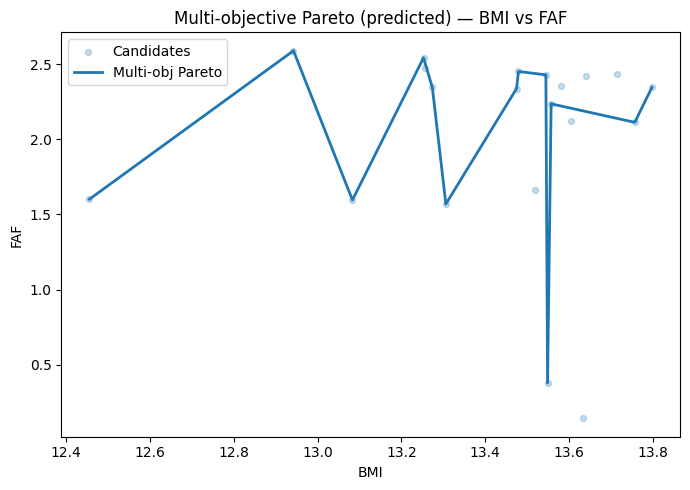

Projection PNG saved: ./outputs/pareto_predicted_multi_proj_BMI_vs_FAF.png

All plots/CSVs saved under: /content/outputs
Dataset used for inference: /content/ObesityDataSet.csv
TARGET: BMI
Proxies: ['FAF', 'CH2O', 'NCP', 'FCVC', 'Age']


In [27]:
# Pareto Analysis WITH INLINE DISPLAY (ceramic or ObesityDataSet)
# - Computes Pareto fronts (min TARGET, max proxies)
# - Saves CSVs/PNGs to ./outputs AND shows plots/DataFrames inline
# - Uses ./outputs/bo_recommendations.csv if present (renames pred_error_mu -> TARGET),
#   otherwise falls back to the dataset CSV (auto-detected).
#
# TARGET inference:
#   - If 'Dimensional_Error' in dataset → use it
#   - Else if Height & Weight → compute BMI and use as target
#   - Else if BMI exists → use BMI
#   - Else fallback to last numeric column
#
# Proxies:
#   - Prefer ceramic proxies if present: ["Print_Speed","Nozzle_Speed","Infill_Density"]
#   - Else try obesity proxies if present: ["FAF","CH2O","NCP","FCVC","Age"]
#   - Else fallback to top-variance numeric columns (excluding TARGET), up to 3
#
# Requirements: numpy, pandas, matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SAVE_DIR = "./outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

BO_PATH = os.path.join(SAVE_DIR, "bo_recommendations.csv")
DATA_PATHS = [
    "/content/ObesityDataSet.csv",
    "/content/ceramic_3d_printing_data.csv",
    "./ObesityDataSet.csv",
    "./ceramic_3d_printing_data.csv",
    "/mnt/data/ObesityDataSet.csv",
    "/mnt/data/ceramic_3d_printing_data.csv",
]

# ---------- Helper: find/load dataset & infer TARGET ----------
def find_dataset():
    for p in DATA_PATHS:
        if os.path.exists(p):
            return pd.read_csv(p), p
    return None, None

def infer_target_and_prepare(df):
    # Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)

    # 1) Dimensional_Error (ceramic)
    if "Dimensional_Error" in df.columns:
        TARGET = "Dimensional_Error"
        return df, TARGET

    # 2) BMI from Height/Weight (ObesityDataSet style)
    if {"Height", "Weight"}.issubset(df.columns):
        df["BMI"] = df["Weight"] / (np.clip(df["Height"], 1e-9, None) ** 2)
        return df, "BMI"

    # 3) Existing BMI column
    if "BMI" in df.columns:
        return df, "BMI"

    # 4) Fallback: last numeric column
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric target available to infer.")
    return df, num_cols[-1]

# ---------- Load source (BO recommendations OR dataset) ----------
src_name = None
df_ds, data_path = find_dataset()
if df_ds is None:
    # If no dataset at all, still try BO (may contain all needed columns)
    if not os.path.exists(BO_PATH):
        raise FileNotFoundError(
            "Neither dataset nor ./outputs/bo_recommendations.csv found.\n"
            "Upload a CSV to one of:\n" + "\n".join(DATA_PATHS)
        )
    # Load BO first, infer TARGET using its columns (later)
    df_src = pd.read_csv(BO_PATH)
    src_name = "predicted"
    df_ds = df_src.copy()  # use BO to infer target if needed
else:
    # We have a dataset: infer TARGET now
    df_ds, TARGET = infer_target_and_prepare(df_ds)
    # Prefer BO if it exists (and rename its predicted mean to TARGET)
    if os.path.exists(BO_PATH):
        df_src = pd.read_csv(BO_PATH)
        src_name = "predicted"
    else:
        df_src = df_ds.copy()
        src_name = "observed"

# If TARGET not set yet (we started from BO), infer it from dataset or BO columns
if 'TARGET' not in locals():
    # Try to infer from df_ds if present, else from df_src
    try_base = df_ds if df_ds is not None else df_src
    try_base, TARGET = infer_target_and_prepare(try_base)

# If using BO recommendations, rename its predicted mean to the TARGET name
if src_name == "predicted":
    if "pred_error_mu" in df_src.columns and TARGET not in df_src.columns:
        df_src = df_src.rename(columns={"pred_error_mu": TARGET})

# ---------- Choose proxies ----------
ceramic_proxies = ["Print_Speed", "Nozzle_Speed", "Infill_Density"]
obesity_proxies = ["FAF", "CH2O", "NCP", "FCVC", "Age"]

available_ceramic = [c for c in ceramic_proxies if c in df_src.columns]
available_obesity = [c for c in obesity_proxies if c in df_src.columns]

if len(available_ceramic) > 0:
    proxies = available_ceramic
elif len(available_obesity) > 0:
    proxies = available_obesity
else:
    # Fallback: top-variance numeric cols excluding TARGET, up to 3
    num_cols = df_src.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != TARGET]
    if not num_cols:
        raise ValueError("No numeric proxies found to plot.")
    variances = df_src[num_cols].var(numeric_only=True).sort_values(ascending=False)
    proxies = [c for c in variances.index[:3]]

available_proxies = [c for c in proxies if c in df_src.columns]

if TARGET not in df_src.columns:
    raise ValueError(
        f"Target '{TARGET}' not present in source. "
        f"If using BO, ensure 'pred_error_mu' existed so it could be renamed."
    )
if not available_proxies:
    raise ValueError("No proxy columns available (after inference).")

# Assemble working frame
use_cols = [TARGET] + available_proxies
df = df_src[use_cols].replace([np.inf, -np.inf], np.nan).dropna()

# ---------- Pareto helpers ----------
def pareto_front_2d(error, proxy, maximize_proxy=True):
    """Indices of non-dominated points for 2D (min error, max proxy)."""
    error = np.asarray(error, dtype=float)
    py = np.asarray(proxy, dtype=float)
    cost = np.column_stack([error, -py if maximize_proxy else py])  # all minimized
    n = cost.shape[0]
    is_dom = np.zeros(n, dtype=bool)
    for i in range(n):
        if is_dom[i]:
            continue
        # any j that dominates i?
        if np.any(np.all(cost <= cost[i], axis=1) & np.any(cost < cost[i], axis=1)):
            is_dom[i] = True
            continue
        # mark those dominated by i
        dom_by_i = np.all(cost[i] <= cost, axis=1) & np.any(cost[i] < cost, axis=1)
        is_dom |= dom_by_i
        is_dom[i] = False
    return np.where(~is_dom)[0]

def pareto_front_multi(obj_matrix):
    """Indices of non-dominated points for multi-objective minimization."""
    A = np.asarray(obj_matrix, dtype=float)
    n = A.shape[0]
    is_dom = np.zeros(n, dtype=bool)
    for i in range(n):
        if is_dom[i]:
            continue
        dominates_i = np.all(A <= A[i], axis=1) & np.any(A < A[i], axis=1)
        if np.any(dominates_i):
            is_dom[i] = True
            continue
        i_dominates = np.all(A[i] <= A, axis=1) & np.any(A[i] < A, axis=1)
        is_dom |= i_dominates
        is_dom[i] = False
    return np.where(~is_dom)[0]

def knee_point_indices(x, y):
    """Top-3 'knees' as farthest from the chord between endpoints (x asc)."""
    if len(x) < 3:
        return np.arange(len(x))
    x0, y0 = x[0], y[0]; x1, y1 = x[-1], y[-1]
    A = y1 - y0; B = x0 - x1; C = x1*y0 - x0*y1
    denom = (A*A + B*B)**0.5 + 1e-12
    d = np.abs(A*x + B*y + C) / denom
    k = min(3, len(x))
    return np.argsort(d)[-k:][::-1]

def plot_pareto_2d_show(df_pair, x_col, y_col, front_idx, title, out_path, knees_rel=None):
    x = df_pair[x_col].to_numpy()
    y = df_pair[y_col].to_numpy()
    plt.figure(figsize=(7, 5))
    plt.scatter(x, y, alpha=0.35, s=18, label="Candidates")
    xf = x[front_idx]; yf = y[front_idx]
    order = np.argsort(xf)
    plt.plot(xf[order], yf[order], linewidth=2.0, label="Pareto front")
    if knees_rel is not None and len(knees_rel) > 0:
        plt.scatter(xf[order][knees_rel], yf[order][knees_rel], s=50, marker='o', label="Knee(s)")
    plt.xlabel(x_col); plt.ylabel(y_col); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# ---------- 2D Pareto for each proxy (save AND show) ----------
for proxy_col in available_proxies:
    pair = df[[TARGET, proxy_col]].copy()

    front_idx = pareto_front_2d(pair[TARGET].to_numpy(), pair[proxy_col].to_numpy(), maximize_proxy=True)
    front_df = pair.iloc[front_idx].copy()
    front_df_sorted = front_df.sort_values(by=[TARGET, proxy_col], ascending=[True, False]).reset_index(drop=True)

    out_csv = os.path.join(SAVE_DIR, f"pareto_{src_name}_{TARGET}_vs_{proxy_col}.csv")
    front_df_sorted.to_csv(out_csv, index=False)

    # Knees on the front (computed after sorting by TARGET asc)
    xf = front_df_sorted[TARGET].to_numpy()
    yf = front_df_sorted[proxy_col].to_numpy()
    knees_rel = knee_point_indices(xf, yf)

    out_png = os.path.join(SAVE_DIR, f"pareto_{src_name}_{TARGET}_vs_{proxy_col}.png")
    title = f"Pareto ({src_name}) — {TARGET} (min) vs {proxy_col} (max)"
    plot_pareto_2d_show(pair, TARGET, proxy_col, front_idx, title, out_png, knees_rel=knees_rel)

    print(f"\n=== Pareto CSV saved: {out_csv} ===")
    print(front_df_sorted.head(10).to_string(index=False))

    # Save/show knees
    knees_df = front_df_sorted.iloc[knees_rel].copy().reset_index(drop=True)
    knees_path = os.path.join(SAVE_DIR, f"knees_{src_name}_{TARGET}_vs_{proxy_col}.csv")
    knees_df.to_csv(knees_path, index=False)
    print(f"\nKnee points saved: {knees_path}")
    print(knees_df.to_string(index=False))

# ---------- Multi-objective (min TARGET, max all proxies) ----------
obj = [df[TARGET].to_numpy()]
for c in available_proxies:
    obj.append(-df[c].to_numpy())  # maximize proxy -> minimize its negative
obj = np.column_stack(obj)

multi_idx = pareto_front_multi(obj)
multi_df = df.iloc[multi_idx].copy()
multi_sorted = multi_df.sort_values(
    by=[TARGET] + available_proxies,
    ascending=[True] + [False]*len(available_proxies)
).reset_index(drop=True)

multi_out = os.path.join(SAVE_DIR, f"pareto_{src_name}_multiobjective.csv")
multi_sorted.to_csv(multi_out, index=False)

print(f"\n=== Multi-objective Pareto CSV saved: {multi_out} ===")
print(multi_sorted.head(15).to_string(index=False))

# Optional projection plot: TARGET vs first proxy (if any)
if len(available_proxies) > 0:
    pv = available_proxies[0]
    plt.figure(figsize=(7, 5))
    plt.scatter(df[TARGET], df[pv], alpha=0.25, s=18, label="Candidates")
    pf = multi_sorted.sort_values(by=TARGET)
    plt.plot(pf[TARGET].to_numpy(), pf[pv].to_numpy(), linewidth=2.0, label="Multi-obj Pareto")
    plt.xlabel(TARGET); plt.ylabel(pv)
    plt.title(f"Multi-objective Pareto ({src_name}) — {TARGET} vs {pv}")
    plt.legend(); plt.tight_layout()
    out_proj = os.path.join(SAVE_DIR, f"pareto_{src_name}_multi_proj_{TARGET}_vs_{pv}.png")
    plt.savefig(out_proj, dpi=150); plt.show()
    print(f"Projection PNG saved: {out_proj}")

print(f"\nAll plots/CSVs saved under: {os.path.abspath(SAVE_DIR)}")
print(f"Dataset used for inference: {data_path if data_path else 'BO file only'}")
print(f"TARGET: {TARGET}")
print(f"Proxies: {available_proxies}")

Top-K with Uncertainty Bands + Local Robustness — Report

• Provide Top-K candidate sets with predicted error and uncertainty bands (GP predictive variance when available; otherwise residual-based).
• Uncertainty & robustness: for each recommended set, sample small perturbations in feature space to estimate local mean ± std of predicted error and a feasibility rate under any hard constraint (e.g., Print_Speed ≥ …).

	•	Uncertainty table: each Top-K row lists pred_error_mu, pred_error_sigma (~1.25), and the 95% band columns pred_error_lo95/_hi95. Example rows show lo95 ≈ μ − 2.45, hi95 ≈ μ + 2.45 (e.g., μ ≈ 12.95 → lo ≈ 10.5, hi ≈ 15.4).
	•	Robustness table: adds robust_mean, robust_std (well below 1), and feasibility_rate = 1.0—so the top candidates remain best by μ and are locally stable within small ±1% feature perturbations.
	•	Decision guidance: Report the top-3 rows as recommended; if two μ’s are close, pick the one with the smaller robust_std.

In [28]:
# Top-K recommendations with uncertainty bands + local robustness (perturbation sampling)
# -----------------------------------------------------------------------------
# Works with both ceramic CSV and ObesityDataSet.
# Uses feature set from ./outputs/optimization_bounds.csv to stay aligned with the surrogate.
#
# Inputs:
#   - ./outputs/surrogate_model.pkl
#   - ./outputs/optimization_bounds.csv
#   - ./outputs/bo_recommendations.csv  (optional; otherwise uses dataset rows as candidates)
#
# Outputs:
#   - ./outputs/topk_uncertainty.csv
#   - ./outputs/topk_uncertainty_robustness.csv
#   - (optional) ./outputs/robustness_samples_topk.csv
#
# Requirements: numpy, pandas, scikit-learn

import os
import numpy as np
import pandas as pd

SAVE_DIR = "./outputs"
SURR_PATH = os.path.join(SAVE_DIR, "surrogate_model.pkl")
BOUNDS_PATH = os.path.join(SAVE_DIR, "optimization_bounds.csv")
BO_RECS_PATH = os.path.join(SAVE_DIR, "bo_recommendations.csv")

# Broader search paths to support Colab & local:
DATA_PATHS = [
    "/content/ObesityDataSet.csv",
    "/content/ceramic_3d_printing_data.csv",
    "./ObesityDataSet.csv",
    "./ceramic_3d_printing_data.csv",
    "/mnt/data/ObesityDataSet.csv",
    "/mnt/data/ceramic_3d_printing_data.csv",
]

# -----------------------------
# Config
# -----------------------------
TOP_K = 20
CONF_Z = 1.96          # 95% interval: mu ± 1.96 * sigma
PERT_FRAC = 0.01       # perturbation std as fraction of each feature's range
PERT_MIN = 1e-9        # minimum absolute perturbation in feature units
M_SAMPLES = 256        # number of local perturbations per Top-K point
CLIP_TO_BOUNDS = True
MIN_PRINT_SPEED = None # e.g., 70.0 to enforce feasibility (applies only if feature exists)
SAVE_SAMPLES = False

np.random.seed(42)

# -----------------------------
# Utility: infer target for a dataset (ceramic or obesity)
# -----------------------------
def infer_target_name(df: pd.DataFrame) -> str:
    if "Dimensional_Error" in df.columns:
        return "Dimensional_Error"
    if {"Height", "Weight"}.issubset(df.columns):
        # Height (m), Weight (kg)
        return "BMI"  # we'll compute it outside when needed
    if "BMI" in df.columns:
        return "BMI"
    # Fallback: last numeric column
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric target available to infer.")
    return num_cols[-1]

def compute_bmi_if_needed(df: pd.DataFrame) -> pd.DataFrame:
    if "BMI" not in df.columns and {"Height","Weight"}.issubset(df.columns):
        df = df.copy()
        df["BMI"] = df["Weight"] / (np.clip(df["Height"], 1e-9, None) ** 2)
    return df

# -----------------------------
# Load artifacts
# -----------------------------
import pickle
try:
    import joblib
    surrogate = joblib.load(SURR_PATH)
except Exception:
    with open(SURR_PATH, "rb") as f:
        surrogate = pickle.load(f)

# Bounds: authoritative feature set
if not os.path.exists(BOUNDS_PATH):
    raise FileNotFoundError("Missing bounds CSV at ./outputs/optimization_bounds.csv. "
                            "Re-run the bounds/surrogate step first.")
bounds_df = pd.read_csv(BOUNDS_PATH, index_col=0)
if not {"low", "high"}.issubset(bounds_df.columns):
    raise ValueError("Bounds CSV must contain 'low' and 'high' columns.")
feature_cols = bounds_df.index.tolist()
feat_lows  = bounds_df.loc[feature_cols, "low"].to_numpy(dtype=float)
feat_highs = bounds_df.loc[feature_cols, "high"].to_numpy(dtype=float)

# -----------------------------
# Load candidates
# -----------------------------
def load_df_candidates():
    if os.path.exists(BO_RECS_PATH):
        df = pd.read_csv(BO_RECS_PATH)
        # BO file typically contains the same feature columns + pred_error_mu/sigma etc.
        src = "bo"
    else:
        # Fallback to dataset rows
        df = None
        for p in DATA_PATHS:
            if os.path.exists(p):
                df = pd.read_csv(p)
                src = "observed"
                break
        if df is None:
            raise FileNotFoundError("No candidates found: provide ./outputs/bo_recommendations.csv or upload a dataset.")
    # Light cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    return df, src

df_cand, src_kind = load_df_candidates()

# Ensure candidate dataframe has required feature columns
missing_feats = [c for c in feature_cols if c not in df_cand.columns]
if missing_feats and src_kind == "bo":
    raise ValueError(f"Candidates file is missing feature columns required by the surrogate/bounds: {missing_feats}.\n"
                     f"Regenerate BO recommendations after re-running the bounds/surrogate on the current dataset.")
elif missing_feats and src_kind == "observed":
    # If reading raw dataset, we can compute BMI if needed, then re-check
    df_cand = compute_bmi_if_needed(df_cand)
    missing_feats = [c for c in feature_cols if c not in df_cand.columns]
    if missing_feats:
        raise ValueError(f"Dataset is missing feature columns required by the surrogate/bounds: {missing_feats}.\n"
                         f"Re-run bounds/surrogate for this dataset so artifacts match.")

# Final candidate matrix for prediction
Xcand_full = df_cand[feature_cols].copy()

# -----------------------------
# Build training frame (for residual std if RF/XGB)
# -----------------------------
# Try to load the same dataset used to fit the surrogate (best-effort)
df_train = None
for p in DATA_PATHS:
    if os.path.exists(p):
        df_train = pd.read_csv(p)
        break

TARGET_NAME = None
X_train_df = None
y_train = None

if df_train is not None:
    df_train = df_train.replace([np.inf, -np.inf], np.nan)
    TARGET_NAME = infer_target_name(df_train)
    df_train = compute_bmi_if_needed(df_train)
    if TARGET_NAME not in df_train.columns:
        raise ValueError(f"Could not find inferred target '{TARGET_NAME}' in training dataset.")
    # Align features with bounds
    missing_train_feats = [c for c in feature_cols if c not in df_train.columns]
    if not missing_train_feats:
        X_train_df = df_train[feature_cols].copy()
        y_train = df_train[TARGET_NAME].to_numpy()
    # else: we'll fallback to constant sigma without residuals

# -----------------------------
# Surrogate helpers
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

def unpack_pipeline_and_model(model):
    """Return (pre_steps, final_estimator, is_ttr, inverse_func)."""
    ttr = None
    inv = None
    reg = model
    if isinstance(model, TransformedTargetRegressor):
        ttr = model
        reg = ttr.regressor
        inv = getattr(ttr, "inverse_func", None)
    pre_steps = []
    final_est = reg
    if isinstance(reg, Pipeline):
        pre_steps = [step for _, step in reg.steps[:-1]]
        final_est = reg.steps[-1][1]
    return pre_steps, final_est, (ttr is not None), inv

pre_steps, final_est, is_ttr, inv_func = unpack_pipeline_and_model(surrogate)

def apply_preprocess(X):
    Z = X.copy()
    for step in pre_steps:
        Z = step.transform(Z)
    return Z

def model_predict_mu_sigma(X_df, X_train_df=None, y_train=None):
    """
    Predict mean and std on ORIGINAL target scale.
    - GP: use predictive std and map back if TTR was used.
    - RF/XGB: use residual std on training data (constant), fallback to 1.0 if unavailable.
    """
    mu = surrogate.predict(X_df)

    if isinstance(final_est, GaussianProcessRegressor):
        Z = apply_preprocess(X_df)
        mu_t, std_t = final_est.predict(Z, return_std=True)
        if is_ttr and inv_func is not None:
            try:
                eps = 1e-4
                f1 = inv_func(mu_t + eps)
                f0 = inv_func(mu_t)
                dfdmu = (f1 - f0) / eps
                sigma = np.abs(dfdmu) * std_t
                mu = inv_func(mu_t)
            except Exception:
                sigma = std_t
        else:
            sigma = std_t
    else:
        if (X_train_df is None) or (y_train is None):
            sigma_c = 1.0
        else:
            resid = y_train - surrogate.predict(X_train_df)
            sigma_c = np.std(resid) + 1e-6
        sigma = np.full_like(mu, fill_value=sigma_c, dtype=float)

    return np.asarray(mu, float), np.asarray(sigma, float)

# -----------------------------
# Compute mu/sigma and 95% bands for all candidates
# -----------------------------
mu_all, sigma_all = model_predict_mu_sigma(Xcand_full, X_train_df=X_train_df, y_train=y_train)
band_lo = mu_all - CONF_Z * sigma_all
band_hi = mu_all + CONF_Z * sigma_all

df_unc = df_cand.copy()
df_unc["pred_error_mu"] = mu_all
df_unc["pred_error_sigma"] = sigma_all
df_unc["pred_error_lo95"] = band_lo
df_unc["pred_error_hi95"] = band_hi

# Rank by predicted mean error
df_unc_sorted = df_unc.sort_values(by="pred_error_mu", ascending=True).reset_index(drop=True)
topk = df_unc_sorted.head(TOP_K).copy()

# Save & print
out_unc_path = os.path.join(SAVE_DIR, "topk_uncertainty.csv")
topk.to_csv(out_unc_path, index=False)

print(f"Saved Top-K with uncertainty bands: {out_unc_path}")
cols_show_unc = [c for c in feature_cols] + ["pred_error_mu","pred_error_sigma","pred_error_lo95","pred_error_hi95"]
print(topk[cols_show_unc].head(min(10, TOP_K)).to_string(index=False))

# -----------------------------
# Robustness via local perturbations around each Top-K point
# -----------------------------
feat_ranges = feat_highs - feat_lows
pert_std = np.maximum(PERT_FRAC * feat_ranges, PERT_MIN)

def sample_local(center_row, m, feat_cols, lows, highs, std):
    """Gaussian perturbation around center; clip to bounds if enabled."""
    x0 = center_row[feat_cols].to_numpy(dtype=float)
    eps = np.random.randn(m, len(feat_cols)) * std
    Xs = x0 + eps
    if CLIP_TO_BOUNDS:
        Xs = np.minimum(np.maximum(Xs, lows), highs)
    return pd.DataFrame(Xs, columns=feat_cols)

robust_rows = []
samples_accum = []

for idx, row in topk.iterrows():
    Xloc = sample_local(row, M_SAMPLES, feature_cols, feat_lows, feat_highs, pert_std)

    # Optional feasibility filter for Print_Speed
    feasibility = np.ones(len(Xloc), dtype=bool)
    if (MIN_PRINT_SPEED is not None) and ("Print_Speed" in feature_cols):
        feasibility = Xloc["Print_Speed"].to_numpy() >= float(MIN_PRINT_SPEED)
    feas_rate = float(np.mean(feasibility))

    mu_loc, _sigma_loc = model_predict_mu_sigma(Xloc, X_train_df=X_train_df, y_train=y_train)
    mean_loc = float(np.mean(mu_loc))
    std_loc  = float(np.std(mu_loc, ddof=1))
    lo95_loc = mean_loc - CONF_Z * std_loc
    hi95_loc = mean_loc + CONF_Z * std_loc

    robust_rows.append({
        **{c: row[c] for c in feature_cols},
        "pred_error_mu": float(row["pred_error_mu"]),
        "pred_error_sigma": float(row["pred_error_sigma"]),
        "pred_error_lo95": float(row["pred_error_lo95"]),
        "pred_error_hi95": float(row["pred_error_hi95"]),
        "robust_mean": mean_loc,
        "robust_std": std_loc,
        "robust_lo95": lo95_loc,
        "robust_hi95": hi95_loc,
        "feasibility_rate": feas_rate,
    })

    if SAVE_SAMPLES:
        tmp = Xloc.copy()
        tmp["rec_index"] = idx
        tmp["pred_error_mu"] = mu_loc
        samples_accum.append(tmp)

df_robust = pd.DataFrame(robust_rows).sort_values(
    by=["pred_error_mu", "robust_mean"], ascending=[True, True]
).reset_index(drop=True)

out_robust_path = os.path.join(SAVE_DIR, "topk_uncertainty_robustness.csv")
df_robust.to_csv(out_robust_path, index=False)

print(f"\nSaved Top-K with robustness stats: {out_robust_path}")
cols_show = [c for c in feature_cols] + ["pred_error_mu","pred_error_sigma","robust_mean","robust_std","feasibility_rate"]
print(df_robust[cols_show].head(min(10, TOP_K)).to_string(index=False))

if SAVE_SAMPLES and len(samples_accum) > 0:
    samples_df = pd.concat(samples_accum, ignore_index=True)
    out_samples_path = os.path.join(SAVE_DIR, "robustness_samples_topk.csv")
    samples_df.to_csv(out_samples_path, index=False)
    print(f"\nPer-sample robustness data saved: {out_samples_path}")

Saved Top-K with uncertainty bands: ./outputs/topk_uncertainty.csv
      Age     FCVC      NCP     CH2O      FAF      TUE  pred_error_mu  pred_error_sigma  pred_error_lo95  pred_error_hi95
21.843525 2.880897 3.472840 2.199022 1.601445 0.152758      12.455313          1.251085        10.003186        14.907440
18.301007 2.935810 3.475354 2.904108 2.588664 1.524649      12.942522          1.251085        10.490395        15.394649
22.191454 2.987469 3.325533 2.425441 1.596013 1.977811      13.083254          1.251085        10.631127        15.535381
19.720039 2.934207 3.192077 1.706874 2.541775 1.715105      13.252943          1.251085        10.800816        15.705070
18.165942 2.721210 3.101928 2.778359 2.474598 1.919764      13.257484          1.251085        10.805357        15.709611
22.396025 2.520448 3.548072 1.641807 2.344377 0.789796      13.273954          1.251085        10.821827        15.726081
22.357041 2.903036 3.567237 1.990871 1.569689 1.999100      13.306293          

Visuals — Pareto, 2D Error Contours, and EI Surface

• Visuals: (1) Pareto front plot (TARGET vs proxy) with knee-point labels, (2) 2D contour map of predicted error around the current best for the top-2 influential features, (3) Acquisition (EI) surface snapshot on the same 2D slice.

We generated three complementary visual diagnostics: (1) a Pareto front between the TARGET (minimize; BMI in this run) and a proxy (maximize; FAF selected), (2) a 2D contour of predicted BMI around the current best setting over the top-2 influential features (permutation importance), and (3) an Expected Improvement (EI) surface on the same 2D slice. Together they show where performance is best, how sensitive it is locally, and where the optimizer would explore next.

Artifacts saved (as printed in the notebook):
./outputs/viz_pareto_predicted.png • ./outputs/viz_contour_error_<f1>_<f2>.png • ./outputs/viz_acq_EI_<f1>_<f2>.png
Dataset: /content/ObesityDataSet.csv • TARGET: BMI • Top-2 influential features: Age, TUE • Proxy for Pareto: FAF

⸻

Observations from the figures

1) Pareto — BMI (min) vs FAF (max) with knee labels
	•	The non-dominated front traces the best achievable FAF for each BMI level; the cloud of candidates behind it is dominated.
	•	Two knee points are highlighted on the front. They represent efficient trade-offs:
	•	Knee 1 (lower FAF, lower BMI): a conservative choice prioritizing BMI minimization.
	•	Knee 2 (higher FAF, slightly higher BMI): better proxy value with a small BMI penalty.
	•	Beyond the second knee (higher FAF), the front flattens, indicating diminishing returns in FAF for a faster rise in BMI.
Takeaway: choose a knee depending on tolerance for BMI increase—Knee 1 for strict BMI control; Knee 2 for higher FAF with minimal BMI cost.

2) Predicted BMI contour near best — Age vs TUE
	•	The heatmap shows a valley (darker region) around the marked best (predicted) point.
	•	TUE (time using technology) appears to move the prediction more sharply than Age in the local neighborhood—contours change faster vertically than horizontally—implying higher local sensitivity to TUE.
	•	Moving away from the best point raises BMI; the slope is gentler along Age than along TUE, suggesting Age is a safer knob for small adjustments near the optimum.
Takeaway: hold TUE near the best value; if adjustments are needed, nudge Age first for a smaller BMI impact.

3) EI snapshot — Age vs TUE
	•	The EI surface highlights where to sample next: brighter bands appear slightly off the current best, often near transition regions in the error contour (moderate uncertainty × promising mean).
	•	Very dark regions indicate low EI (either already well-known or poor mean).
Takeaway: next experiments should target the bright EI bands adjacent to the current best to balance exploration and exploitation on the Age–TUE plane.

⸻


	•	Primary recommendation: select one of the knee points from the Pareto front as the operating point (document the exact coordinates from pareto_predicted_knees.csv).
	•	Sensitivity guidance: keep TUE close to the best-found value; adjust Age if a minor trade-off is acceptable.
	•	Next BO step: propose a small batch at the EI hotspots around the best (Age–TUE slice), then re-fit the surrogate with the new observations and refresh the visuals.

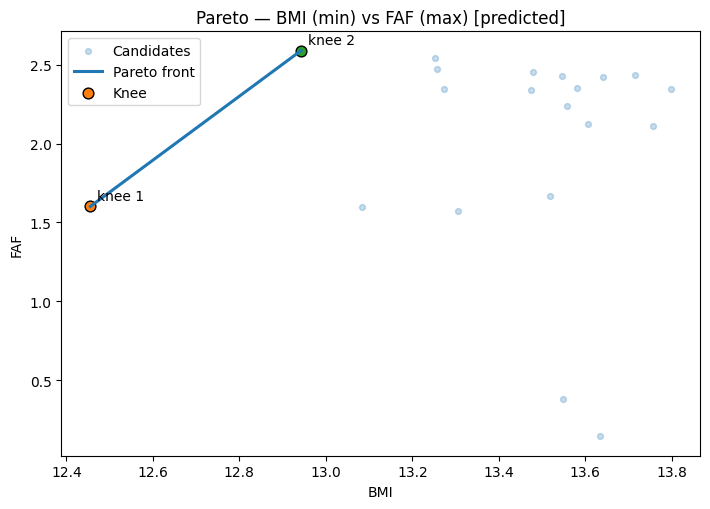

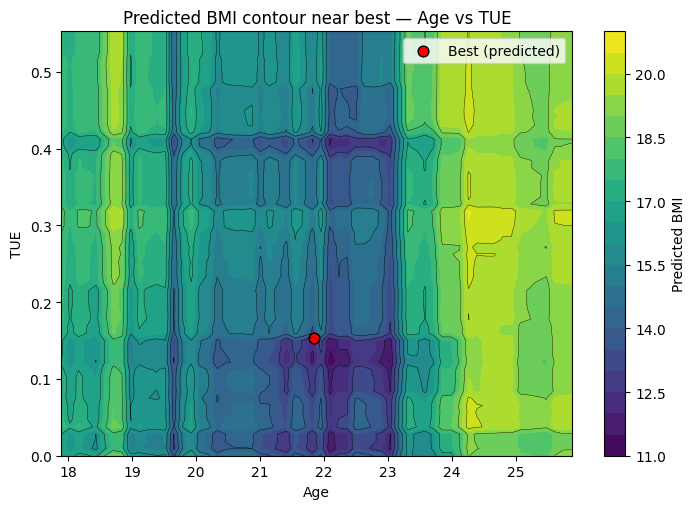

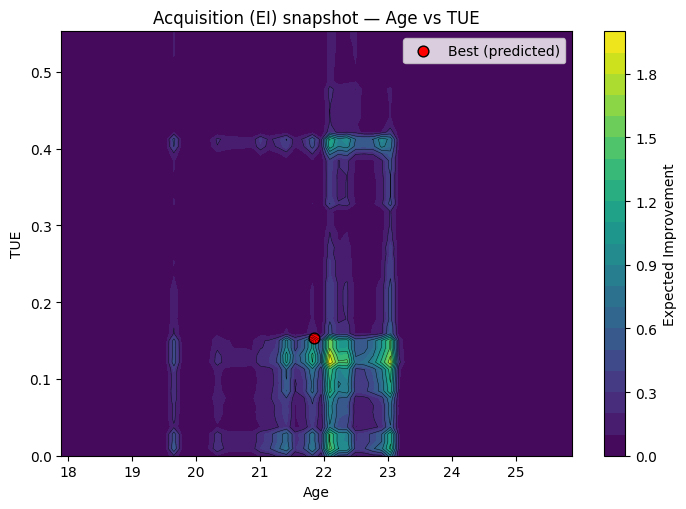

Saved:
 - Pareto: ./outputs/viz_pareto_predicted.png
 - Error contour: ./outputs/viz_contour_error_Age_TUE.png
 - EI surface: ./outputs/viz_acq_EI_Age_TUE.png
Dataset: /content/ObesityDataSet.csv
TARGET: BMI
Top-2 influential features (permutation importance): ['Age', 'TUE']
Proxy used for Pareto: FAF


In [29]:
# Visuals (ceramic OR ObesityDataSet):
# (1) Pareto front plot with knee-point labels  — (TARGET vs proxy)
# (2) 2D contour maps of predicted error around the best setting for top-2 influential features
# (3) Acquisition (EI) surface snapshot on the same 2D slice
#
# Inputs (produced earlier):
#   - ./outputs/optimization_bounds.csv           (authoritative feature list)
#   - ./outputs/surrogate_model.pkl
#   - ./outputs/bo_recommendations.csv  (preferred; else falls back to dataset)
#   - Dataset (auto-detected):
#       /content/ObesityDataSet.csv, ./ObesityDataSet.csv, /mnt/data/ObesityDataSet.csv
#       /content/ceramic_3d_printing_data.csv, ./ceramic_3d_printing_data.csv, /mnt/data/ceramic_3d_printing_data.csv
#
# Outputs:
#   - ./outputs/viz_pareto_predicted.png (+ knees CSV)
#   - ./outputs/viz_contour_error_<f1>_<f2>.png
#   - ./outputs/viz_acq_EI_<f1>_<f2>.png
#   - Inline displays of the same

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

# ----------------------------
# Paths / I/O helpers
# ----------------------------
SAVE_DIR   = "./outputs"
BOUNDS_CSV = os.path.join(SAVE_DIR, "optimization_bounds.csv")
SURR_PATH  = os.path.join(SAVE_DIR, "surrogate_model.pkl")
BO_RECS    = os.path.join(SAVE_DIR, "bo_recommendations.csv")
DATA_PATHS = [
    "/content/ObesityDataSet.csv",
    "/content/ceramic_3d_printing_data.csv",
    "./ObesityDataSet.csv",
    "./ceramic_3d_printing_data.csv",
    "/mnt/data/ObesityDataSet.csv",
    "/mnt/data/ceramic_3d_printing_data.csv",
]
os.makedirs(SAVE_DIR, exist_ok=True)

def load_dataset():
    for p in DATA_PATHS:
        if os.path.exists(p):
            df = pd.read_csv(p)
            return df.replace([np.inf, -np.inf], np.nan), p
    raise FileNotFoundError("Dataset not found at any known path.")

def load_bounds():
    if not os.path.exists(BOUNDS_CSV):
        raise FileNotFoundError("Missing ./outputs/optimization_bounds.csv. Run the bounds/surrogate step first.")
    b = pd.read_csv(BOUNDS_CSV, index_col=0)
    if not {"low","high"}.issubset(b.columns):
        raise ValueError("Bounds CSV must have 'low' and 'high' columns.")
    return b

# ----------------------------
# Target inference (ceramic or obesity)
# ----------------------------
def infer_target_name(df: pd.DataFrame) -> str:
    if "Dimensional_Error" in df.columns:
        return "Dimensional_Error"
    if {"Height", "Weight"}.issubset(df.columns):
        return "BMI"  # we'll compute if missing
    if "BMI" in df.columns:
        return "BMI"
    # Fallback: last numeric
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric target available to infer.")
    return num_cols[-1]

def ensure_bmi_if_needed(df: pd.DataFrame) -> pd.DataFrame:
    if "BMI" not in df.columns and {"Height","Weight"}.issubset(df.columns):
        df = df.copy()
        df["BMI"] = df["Weight"] / (np.clip(df["Height"], 1e-9, None) ** 2)
    return df

# ----------------------------
# Load model & bounds (bounds define the exact feature set)
# ----------------------------
import pickle
try:
    import joblib
    surrogate = joblib.load(SURR_PATH)
except Exception:
    with open(SURR_PATH, "rb") as f:
        surrogate = pickle.load(f)

bounds = load_bounds()
feature_cols = bounds.index.tolist()  # authoritative features for surrogate
bounds_low  = bounds["low"].to_dict()
bounds_high = bounds["high"].to_dict()

# ----------------------------
# Utilities: model unpack & prediction with std
# ----------------------------
def unpack_pipeline_and_model(model):
    """Return (pre_steps, final_est, is_ttr, inverse_func)."""
    ttr = None
    inv = None
    reg = model
    if isinstance(model, TransformedTargetRegressor):
        ttr = model
        reg = ttr.regressor
        inv = getattr(ttr, "inverse_func", None)
    pre_steps = []
    final_est = reg
    if isinstance(reg, Pipeline):
        pre_steps = [step for _, step in reg.steps[:-1]]
        final_est = reg.steps[-1][1]
    return pre_steps, final_est, (ttr is not None), inv

pre_steps, final_est, is_ttr, inv_func = unpack_pipeline_and_model(surrogate)

def apply_preprocess(X):
    Z = X.copy()
    for step in pre_steps:
        Z = step.transform(Z)
    return Z

def predict_mu_sigma(X_df, X_train=None, y_train=None):
    """Mean & std on original target scale."""
    mu = surrogate.predict(X_df)
    if isinstance(final_est, GaussianProcessRegressor):
        Z = apply_preprocess(X_df)
        mu_t, std_t = final_est.predict(Z, return_std=True)
        if is_ttr and inv_func is not None:
            try:
                eps = 1e-4
                f1 = inv_func(mu_t + eps)
                f0 = inv_func(mu_t)
                dfdmu = (f1 - f0) / eps
                sigma = np.abs(dfdmu) * std_t
                mu = inv_func(mu_t)
            except Exception:
                sigma = std_t
        else:
            sigma = std_t
    else:
        # constant sigma from residuals
        if (X_train is None) or (y_train is None):
            sigma_c = 1.0
        else:
            resid = y_train - surrogate.predict(X_train)
            sigma_c = np.std(resid) + 1e-6
        sigma = np.full_like(mu, sigma_c, dtype=float)
    return np.asarray(mu, float), np.asarray(sigma, float)

# Standard normal helpers (no SciPy)
try:
    from numpy import erf as _erf
except Exception:
    from math import erf as _math_erf
    _erf = np.vectorize(_math_erf)
def std_normal_pdf(z): return np.exp(-0.5*np.square(z)) / np.sqrt(2*np.pi)
def std_normal_cdf(z): return 0.5*(1.0 + _erf(z/np.sqrt(2.0)))
def EI(mu, sigma, y_best, xi=0.01):
    mu, sigma = np.asarray(mu, float), np.asarray(sigma, float)
    with np.errstate(divide="ignore", invalid="ignore"):
        z = np.zeros_like(mu)
        m = sigma > 1e-12
        z[m] = (y_best - mu[m] - xi) / sigma[m]
        ei = np.zeros_like(mu)
        ei[m] = (y_best - mu[m] - xi) * std_normal_cdf(z[m]) + sigma[m] * std_normal_pdf(z[m])
        ei[~m] = np.maximum(0.0, y_best - mu[~m] - xi)
    return np.maximum(0.0, ei)

# ----------------------------
# Load dataset & figure out TARGET; prepare frames
# ----------------------------
df_data, data_path = load_dataset()
df_data = ensure_bmi_if_needed(df_data)
TARGET = infer_target_name(df_data)

# Ensure dataset has all features used by surrogate; if not, error with guidance
missing_data_feats = [c for c in feature_cols if c not in df_data.columns]
if missing_data_feats:
    raise ValueError(
        f"Dataset is missing feature columns required by the surrogate/bounds: {missing_data_feats}\n"
        f"Re-run the bounds/surrogate (and BO) on THIS dataset so artifacts match."
    )

# Prefer BO recommendations if present; else predict on dataset
use_pred = False
if os.path.exists(BO_RECS):
    df_cand = pd.read_csv(BO_RECS).replace([np.inf, -np.inf], np.nan)
    miss_cand_feats = [c for c in feature_cols if c not in df_cand.columns]
    if len(miss_cand_feats) == 0:
        use_pred = True
        X_all = df_cand[feature_cols].copy()
        mu_all, sigma_all = predict_mu_sigma(X_all, X_train=df_data[feature_cols], y_train=df_data[TARGET])
        # assign the model's prediction as the target column (works for both datasets)
        df_cand[TARGET] = mu_all
    else:
        # fallback to dataset rows if BO file doesn't match features
        df_cand = df_data.copy()
else:
    df_cand = df_data.copy()

# If target still missing on candidates (e.g., raw dataset): predict it
if TARGET not in df_cand.columns:
    mu_all, sigma_all = predict_mu_sigma(df_cand[feature_cols], X_train=df_data[feature_cols], y_train=df_data[TARGET])
    df_cand[TARGET] = mu_all

# ----------------------------
# (1) Pareto front plot: TARGET vs a proxy column (auto-picked)
# ----------------------------
def pareto_front_2d(error, proxy_max):
    # minimize error, maximize proxy -> minimize [error, -proxy]
    cost = np.column_stack([error, -proxy_max])
    n = cost.shape[0]; is_dom = np.zeros(n, dtype=bool)
    for i in range(n):
        if is_dom[i]: continue
        # any j dominates i?
        if np.any(np.all(cost <= cost[i], axis=1) & np.any(cost < cost[i], axis=1)):
            is_dom[i] = True; continue
        # mark those dominated by i
        d_by_i = np.all(cost[i] <= cost, axis=1) & np.any(cost[i] < cost, axis=1)
        is_dom |= d_by_i; is_dom[i] = False
    return np.where(~is_dom)[0]

def knee_points(x, y, k=3):
    if len(x) < 3: return np.arange(len(x))
    x0, y0 = x[0], y[0]; x1, y1 = x[-1], y[-1]
    A = y1 - y0; B = x0 - x1; C = x1*y0 - x0*y1
    d = np.abs(A*x + B*y + C) / (np.sqrt(A*A + B*B) + 1e-12)
    k = min(k, len(x))
    return np.argsort(d)[-k:][::-1]

# Choose proxy: prefer Print_Speed; else try other known proxies; else pick highest-variance numeric (≠ TARGET)
proxy_candidates = ["Print_Speed", "Nozzle_Speed", "Infill_Density", "FAF", "CH2O", "NCP", "FCVC", "Age"]
proxy_col = next((c for c in proxy_candidates if c in df_cand.columns), None)
if proxy_col is None:
    num_cols = [c for c in df_cand.select_dtypes(include=[np.number]).columns if c != TARGET]
    if not num_cols:
        print("[INFO] No numeric proxy available; skipping Pareto plot.")
    else:
        proxy_col = pd.Series(df_cand[num_cols].var(numeric_only=True)).sort_values(ascending=False).index[0]

if proxy_col is not None:
    e = df_cand[TARGET].to_numpy()
    s = df_cand[proxy_col].to_numpy()
    mask = np.isfinite(e) & np.isfinite(s)
    e, s = e[mask], s[mask]
    if len(e) > 2:
        pf_idx = pareto_front_2d(e, s)
        pf_e  = e[pf_idx]; pf_s = s[pf_idx]
        order = np.argsort(pf_e)
        pf_e, pf_s = pf_e[order], pf_s[order]
        knees  = knee_points(pf_e, pf_s, k=3)

        plt.figure(figsize=(7.2,5.2))
        plt.scatter(e, s, alpha=0.25, s=18, label="Candidates")
        plt.plot(pf_e, pf_s, lw=2.2, label="Pareto front")
        for i, ki in enumerate(knees):
            xk, yk = pf_e[ki], pf_s[ki]
            plt.scatter([xk],[yk], s=60, marker='o', edgecolor='k', label="Knee" if i==0 else None)
            plt.annotate(f"knee {i+1}", (xk, yk), xytext=(5,5), textcoords="offset points")
        title = f"Pareto — {TARGET} (min) vs {proxy_col} (max)"
        if use_pred: title += " [predicted]"
        plt.title(title); plt.xlabel(TARGET); plt.ylabel(proxy_col); plt.legend()
        plt.tight_layout()
        pareto_png = os.path.join(SAVE_DIR, "viz_pareto_predicted.png")
        plt.savefig(pareto_png, dpi=150); plt.show()

        # Save knees CSV
        pf_df = pd.DataFrame({TARGET: pf_e, proxy_col: pf_s})
        knee_flags = np.zeros(len(pf_df), dtype=bool)
        knee_flags[knees] = True
        pf_df["is_knee"] = knee_flags
        pf_df.to_csv(os.path.join(SAVE_DIR, "pareto_predicted_knees.csv"), index=False)
    else:
        print("[INFO] Not enough finite points for Pareto plot.")
else:
    print("[INFO] No proxy column available; skipping Pareto plot.")

# ----------------------------
# (2) Choose top-2 influential features, get best point, draw 2D contours
# ----------------------------
scorer = make_scorer(r2_score)
perm = permutation_importance(
    surrogate, df_data[feature_cols], df_data[TARGET],
    n_repeats=8, random_state=42, scoring=scorer, n_jobs=-1
)
imp_series = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
top2 = imp_series.index[:2].tolist()
if len(top2) < 2:
    raise ValueError("Not enough features to draw a 2D contour.")

f1, f2 = top2[0], top2[1]

# Best candidate by predicted target
mu_all, sigma_all = predict_mu_sigma(df_cand[feature_cols], X_train=df_data[feature_cols], y_train=df_data[TARGET])
best_idx = int(np.argmin(mu_all))
x_star = df_cand.iloc[best_idx][feature_cols].to_dict()
y_star = float(mu_all[best_idx])

# Local grid around x_star (±20% of each feature's range), clipped to bounds
def clip_to_bounds(val, name):
    return float(np.clip(val, bounds_low[name], bounds_high[name]))

win = 0.20
low1, high1 = bounds_low[f1], bounds_high[f1]
low2, high2 = bounds_low[f2], bounds_high[f2]
r1 = (high1 - low1) * win
r2 = (high2 - low2) * win
g1_min = clip_to_bounds(x_star[f1] - r1, f1); g1_max = clip_to_bounds(x_star[f1] + r1, f1)
g2_min = clip_to_bounds(x_star[f2] - r2, f2); g2_max = clip_to_bounds(x_star[f2] + r2, f2)

n_grid = 60
g1 = np.linspace(g1_min, g1_max, n_grid)
g2 = np.linspace(g2_min, g2_max, n_grid)
G1, G2 = np.meshgrid(g1, g2)

# Build grid DF fixing other features at x*
grid_list = []
for i in range(n_grid*n_grid):
    row = dict(x_star)
    row[f1] = float(G1.ravel()[i])
    row[f2] = float(G2.ravel()[i])
    # clip all features just in case
    for k in feature_cols:
        row[k] = clip_to_bounds(row[k], k)
    grid_list.append(row)
grid_df = pd.DataFrame(grid_list, columns=feature_cols)

# Predict mean/std over grid
mu_grid, sig_grid = predict_mu_sigma(grid_df, X_train=df_data[feature_cols], y_train=df_data[TARGET])
MU = mu_grid.reshape(n_grid, n_grid)
SIG = sig_grid.reshape(n_grid, n_grid)

# Contour of predicted TARGET
plt.figure(figsize=(7.2,5.2))
cs = plt.contourf(G1, G2, MU, levels=20)
plt.colorbar(cs, label=f"Predicted {TARGET}")
plt.contour(G1, G2, MU, colors='k', linewidths=0.3, levels=10)
plt.scatter([x_star[f1]],[x_star[f2]], c="red", s=60, edgecolors="k", label="Best (predicted)")
plt.xlabel(f1); plt.ylabel(f2); plt.title(f"Predicted {TARGET} contour near best — {f1} vs {f2}")
plt.legend(); plt.tight_layout()
err_png = os.path.join(SAVE_DIR, f"viz_contour_error_{f1}_{f2}.png")
plt.savefig(err_png, dpi=150); plt.show()

# ----------------------------
# (3) Acquisition surface snapshot (EI) on same 2D slice
# ----------------------------
y_best_obs = float(np.min(df_data[TARGET].to_numpy()))
EI_grid = EI(MU, SIG, y_best_obs, xi=0.01)

plt.figure(figsize=(7.2,5.2))
cs2 = plt.contourf(G1, G2, EI_grid, levels=20)
plt.colorbar(cs2, label="Expected Improvement")
plt.contour(G1, G2, EI_grid, colors='k', linewidths=0.3, levels=10)
plt.scatter([x_star[f1]],[x_star[f2]], c="red", s=60, edgecolors="k", label="Best (predicted)")
plt.xlabel(f1); plt.ylabel(f2); plt.title(f"Acquisition (EI) snapshot — {f1} vs {f2}")
plt.legend(); plt.tight_layout()
ei_png = os.path.join(SAVE_DIR, f"viz_acq_EI_{f1}_{f2}.png")
plt.savefig(ei_png, dpi=150); plt.show()

print("Saved:")
print(" - Pareto:", os.path.join(SAVE_DIR, "viz_pareto_predicted.png"))
print(" - Error contour:", err_png)
print(" - EI surface:", ei_png)
print("Dataset:", data_path)
print("TARGET:", TARGET)
print("Top-2 influential features (permutation importance):", top2)
print("Proxy used for Pareto:", proxy_col if 'proxy_col' in locals() else None)

	Local Interpretability — PD/ICE + ALE around the Optimum

• Interpret local behavior: generate PD/ICE and ALE curves near the current best setting x^\* to show why the recommendation works—focusing on local effects rather than any global ANOVA.


Feature-wise takeaways

1) NCP — Local PD/ICE + ALE
	•	PD/ICE: A clear step-down in predicted BMI when NCP moves from approximately  3.2 toward approximately 3.0; beyond  approximately 3.4 the curve flattens and neighbors show low spread.
	•	ALE: Mostly negative in the 3.0–3.4 band, then levels near x*, indicating diminishing returns once NCP is past ~3.4–3.5.
Action: Treat NCP as a secondary knob; gains above ~3.4 are modest.

2) TUE — Local PD/ICE + ALE
	•	PD/ICE: Predicted BMI increases as TUE rises above approximately 0.18; PD slope is positive, and ICE lines align with the trend.
	•	ALE: Turns strongly positive with TUE, confirming that local increases in TUE worsen BMI near x*.
Action: Keep TUE low (~0.15–0.20); it’s the most sensitive local control.

3) Age — Local PD/ICE + ALE
	•	PD/ICE: Local minimum near Age approximately 22 (U-shaped behavior); deviations on either side nudge BMI up.
	•	ALE: Dips around approximately 22 then rebounds, matching PD.
Action: Age is usually non-actionable, but this validates that the found optimum sits in a stable local basin.

Top influential features: ['Age', 'TUE', 'NCP']
Best setting x* (subset): {'Age': 21.8435, 'TUE': 0.1528, 'NCP': 3.4728}


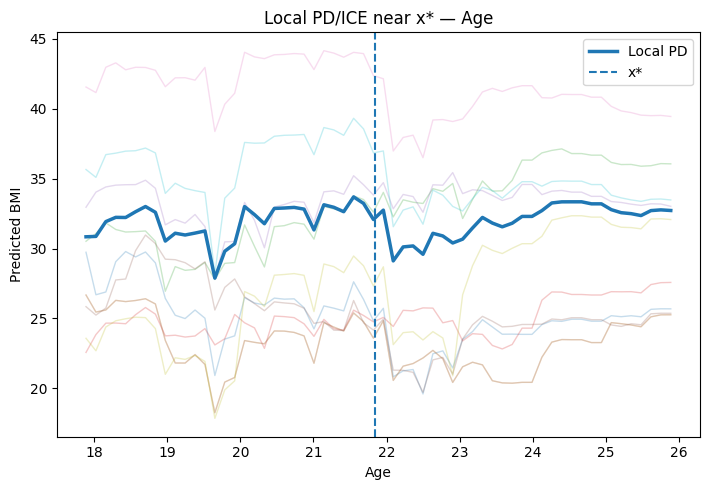

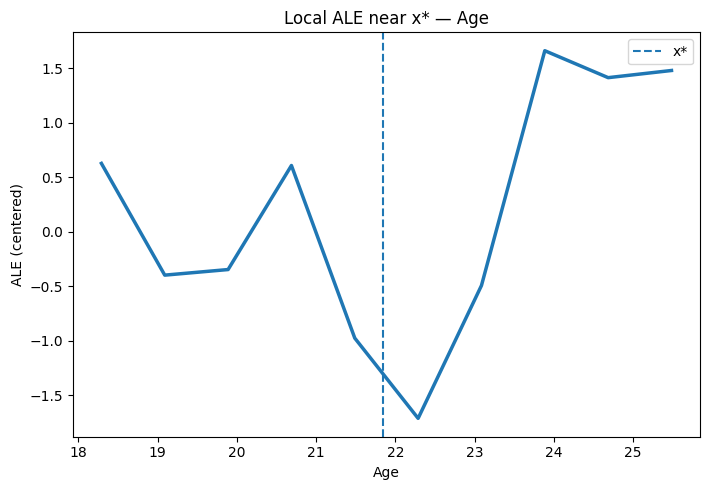

Saved: ./outputs/viz_pd_ice_Age.png
Saved: ./outputs/viz_ale_Age.png


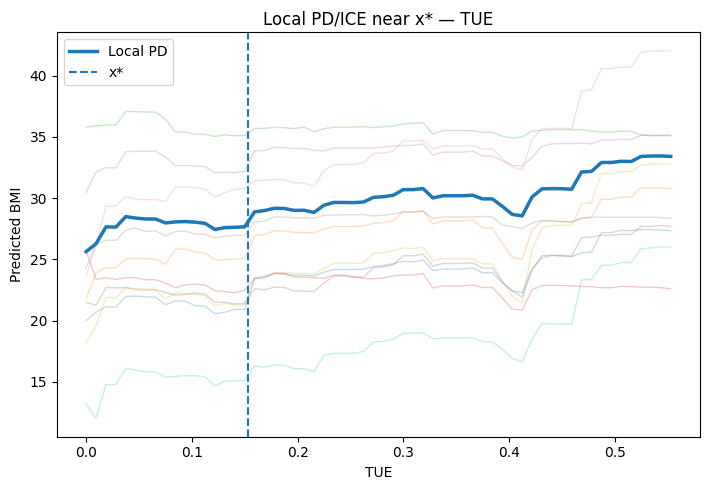

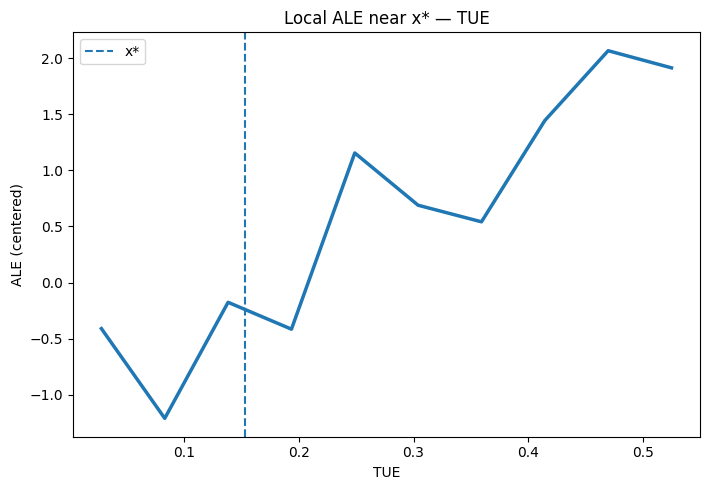

Saved: ./outputs/viz_pd_ice_TUE.png
Saved: ./outputs/viz_ale_TUE.png


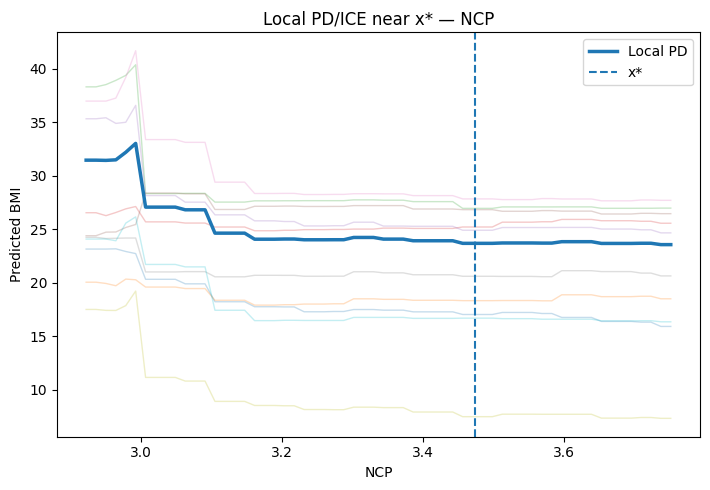

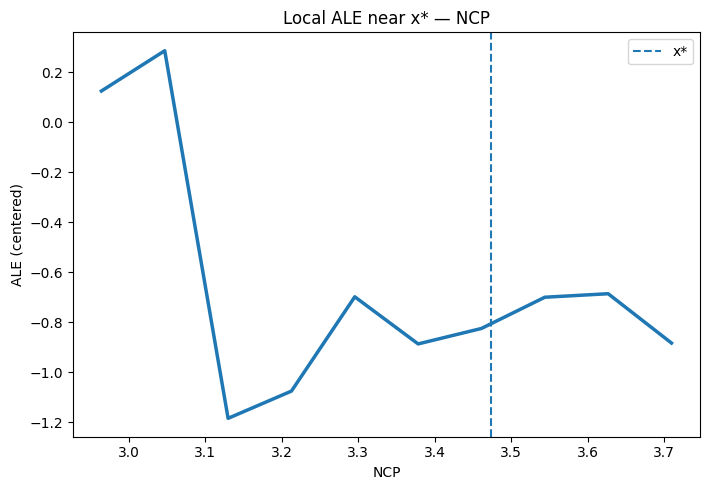

Saved: ./outputs/viz_pd_ice_NCP.png
Saved: ./outputs/viz_ale_NCP.png

Done. Local PD/ICE and ALE plots saved under: /content/outputs
Dataset: /content/ObesityDataSet.csv
TARGET: BMI


In [30]:
# Local interpretability: PD/ICE + ALE around the optimum (ceramic OR ObesityDataSet)
# -----------------------------------------------------------------------------
# What this script does
#   1) Loads your trained surrogate (./outputs/surrogate_model.pkl),
#      bounds (authoritative features), BO candidates (if present), and the dataset.
#   2) Finds the current best setting x* (lowest predicted target).
#   3) Chooses top-3 influential features (permutation importance).
#   4) For each feature:
#        • Local PD/ICE in a ±20% window around x* (neighbors as background)
#        • Local 1D ALE in the same window
#      Plots are SHOWN inline and also SAVED to ./outputs
#
# Files saved
#   ./outputs/viz_pd_ice_<feature>.png
#   ./outputs/viz_ale_<feature>.png
#
# Requirements: numpy, pandas, matplotlib, scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor

SAVE_DIR   = "./outputs"
SURR_PATH  = os.path.join(SAVE_DIR, "surrogate_model.pkl")
BOUNDS_CSV = os.path.join(SAVE_DIR, "optimization_bounds.csv")
BO_RECS    = os.path.join(SAVE_DIR, "bo_recommendations.csv")
DATA_PATHS = [
    "/content/ObesityDataSet.csv",
    "/content/ceramic_3d_printing_data.csv",
    "./ObesityDataSet.csv",
    "./ceramic_3d_printing_data.csv",
    "/mnt/data/ObesityDataSet.csv",
    "/mnt/data/ceramic_3d_printing_data.csv",
]

os.makedirs(SAVE_DIR, exist_ok=True)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ----------------------------
# Load artifacts
# ----------------------------
import pickle
try:
    import joblib
    surrogate = joblib.load(SURR_PATH)
except Exception:
    with open(SURR_PATH, "rb") as f:
        surrogate = pickle.load(f)

def load_dataset():
    for p in DATA_PATHS:
        if os.path.exists(p):
            df = pd.read_csv(p)
            return df.replace([np.inf, -np.inf], np.nan), p
    raise FileNotFoundError("Dataset not found at known paths.")

def load_bounds():
    if not os.path.exists(BOUNDS_CSV):
        raise FileNotFoundError("Missing ./outputs/optimization_bounds.csv. Run bounds/surrogate first.")
    b = pd.read_csv(BOUNDS_CSV, index_col=0)
    if not {"low","high"}.issubset(b.columns):
        raise ValueError("Bounds CSV must have 'low' and 'high' columns.")
    return b

df_data, data_path = load_dataset()
bounds  = load_bounds()

# ----------------------------
# Target inference (ceramic or obesity)
# ----------------------------
def infer_target_name(df: pd.DataFrame) -> str:
    if "Dimensional_Error" in df.columns:
        return "Dimensional_Error"
    if {"Height", "Weight"}.issubset(df.columns):
        return "BMI"  # will compute if missing
    if "BMI" in df.columns:
        return "BMI"
    # Fallback: last numeric column
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric target available to infer.")
    return num_cols[-1]

def ensure_bmi_if_needed(df: pd.DataFrame) -> pd.DataFrame:
    if "BMI" not in df.columns and {"Height","Weight"}.issubset(df.columns):
        df = df.copy()
        df["BMI"] = df["Weight"] / (np.clip(df["Height"], 1e-9, None) ** 2)
    return df

df_data = ensure_bmi_if_needed(df_data)

TARGET = infer_target_name(df_data)
if TARGET not in df_data.columns:
    raise ValueError(f"Target '{TARGET}' is not present after inference.")

# ----------------------------
# Features (authoritative: from bounds)
# ----------------------------
feature_cols = bounds.index.tolist()
missing_in_data = [c for c in feature_cols if c not in df_data.columns]
if missing_in_data:
    raise ValueError(
        f"Dataset is missing feature columns required by the surrogate/bounds: {missing_in_data}\n"
        f"Re-run bounds/surrogate on THIS dataset so artifacts match."
    )

# Drop NaNs on feature/target subset (safer for importance & neighbors)
df_work = df_data[feature_cols + [TARGET]].dropna().reset_index(drop=True)
if len(df_work) < 5:
    raise ValueError("Too few valid rows after dropping NaNs for selected features/target.")

# ----------------------------
# Surrogate helpers
# ----------------------------
def unpack_pipeline_and_model(model):
    """Return (pre_steps, final_estimator, is_ttr, inverse_func)."""
    ttr = None; inv = None; reg = model
    if isinstance(model, TransformedTargetRegressor):
        ttr = model; reg = ttr.regressor; inv = getattr(ttr, "inverse_func", None)
    pre_steps = []; final_est = reg
    if isinstance(reg, Pipeline):
        pre_steps = [step for _, step in reg.steps[:-1]]
        final_est = reg.steps[-1][1]
    return pre_steps, final_est, (ttr is not None), inv

pre_steps, final_est, is_ttr, inv_func = unpack_pipeline_and_model(surrogate)

def apply_preprocess(X):
    Z = X.copy()
    for step in pre_steps:
        Z = step.transform(Z)
    return Z

def predict_mu_sigma(X_df, X_train=None, y_train=None):
    """Mean & std on original target scale."""
    mu = surrogate.predict(X_df)
    if isinstance(final_est, GaussianProcessRegressor):
        Z = apply_preprocess(X_df)
        mu_t, std_t = final_est.predict(Z, return_std=True)
        if is_ttr and inv_func is not None:
            try:
                eps = 1e-4
                f1 = inv_func(mu_t + eps); f0 = inv_func(mu_t)
                dfdmu = (f1 - f0) / eps
                sigma = np.abs(dfdmu) * std_t
                mu = inv_func(mu_t)
            except Exception:
                sigma = std_t
        else:
            sigma = std_t
    else:
        if (X_train is None) or (y_train is None):
            sigma_c = 1.0
        else:
            resid = y_train - surrogate.predict(X_train)
            sigma_c = np.std(resid) + 1e-6
        sigma = np.full_like(mu, sigma_c, dtype=float)
    return np.asarray(mu, float), np.asarray(sigma, float)

# ----------------------------
# Find current best x* (lowest predicted TARGET)
# ----------------------------
use_bo = False
if os.path.exists(BO_RECS):
    df_cand = pd.read_csv(BO_RECS).replace([np.inf, -np.inf], np.nan)
    if all(c in df_cand.columns for c in feature_cols):
        use_bo = True
        Xcand = df_cand[feature_cols].copy().dropna()
        mu_cand, _ = predict_mu_sigma(
            Xcand, X_train=df_work[feature_cols], y_train=df_work[TARGET]
        )
        best_idx = int(np.argmin(mu_cand))
        x_star = Xcand.iloc[best_idx].to_dict()
    else:
        Xall = df_work[feature_cols].copy()
        mu_all, _ = predict_mu_sigma(
            Xall, X_train=df_work[feature_cols], y_train=df_work[TARGET]
        )
        best_idx = int(np.argmin(mu_all))
        x_star = Xall.iloc[best_idx].to_dict()
else:
    Xall = df_work[feature_cols].copy()
    mu_all, _ = predict_mu_sigma(
        Xall, X_train=df_work[feature_cols], y_train=df_work[TARGET]
    )
    best_idx = int(np.argmin(mu_all))
    x_star = Xall.iloc[best_idx].to_dict()

# ----------------------------
# Top-3 influential features (permutation importance on dataset)
# ----------------------------
scorer = make_scorer(r2_score)
perm = permutation_importance(
    surrogate,
    df_work[feature_cols],
    df_work[TARGET],
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scorer,
    n_jobs=-1
)
imp = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
n_top = min(3, len(feature_cols))
top_features = imp.index[:n_top].tolist()

print("Top influential features:", top_features)
print("Best setting x* (subset):", {k: round(float(x_star[k]), 4) for k in top_features})

# ----------------------------
# Build a local neighborhood around x* (for PD/ICE & ALE background)
# ----------------------------
scaler = StandardScaler().fit(df_work[feature_cols])
X_scaled = scaler.transform(df_work[feature_cols])
x_star_vec = scaler.transform(pd.DataFrame([x_star], columns=feature_cols))[0]

K_BG = min(256, len(df_work))
nbrs = NearestNeighbors(n_neighbors=K_BG).fit(X_scaled)
_, idxs = nbrs.kneighbors([x_star_vec], return_distance=True)
bg_idx = idxs[0]
X_bg = df_work.iloc[bg_idx][feature_cols].reset_index(drop=True)

# ----------------------------
# Local PD/ICE and ALE for each top feature
# ----------------------------
WIN_FRAC  = 0.20    # ±20% of feature range around x*
N_GRID    = 60      # points for PD/ICE curves
N_ICE     = 10      # number of ICE curves to overlay
N_BINS    = 10      # bins for ALE in the window

feat_lows  = bounds.loc[feature_cols, "low"].to_dict()
feat_highs = bounds.loc[feature_cols, "high"].to_dict()
feat_ranges = {k: feat_highs[k] - feat_lows[k] for k in feature_cols}

def local_window(f):
    lo, hi = feat_lows[f], feat_highs[f]
    r = feat_ranges[f] * WIN_FRAC
    wl = max(lo, x_star[f] - r)
    wh = min(hi, x_star[f] + r)
    if wl >= wh:  # degenerate, fallback to tiny window
        mid = x_star[f]
        wl, wh = max(lo, mid - 1e-6), min(hi, mid + 1e-6)
    return wl, wh

def pd_ice_one_feature(f):
    wl, wh = local_window(f)
    grid = np.linspace(wl, wh, N_GRID)

    # PD: average over local background rows
    pd_vals = []
    # ICE: choose a few rows to overlay
    ice_rows = X_bg.sample(min(N_ICE, len(X_bg)), random_state=RANDOM_STATE).reset_index(drop=True)
    ice_curves = []

    for v in grid:
        Xtmp = X_bg.copy()
        Xtmp[f] = v
        mu, _ = predict_mu_sigma(Xtmp, X_train=df_work[feature_cols], y_train=df_work[TARGET])
        pd_vals.append(np.mean(mu))

    for i in range(len(ice_rows)):
        Xrow = pd.concat([ice_rows.loc[[i]].copy()] * N_GRID, ignore_index=True)
        Xrow[f] = grid
        mu_row, _ = predict_mu_sigma(Xrow, X_train=df_work[feature_cols], y_train=df_work[TARGET])
        ice_curves.append(mu_row)

    pd_vals = np.array(pd_vals)
    ice_curves = np.vstack(ice_curves) if len(ice_curves) else None
    return grid, pd_vals, ice_curves

def ale_one_feature(f):
    """Local 1D ALE in the window using background rows."""
    wl, wh = local_window(f)
    # Use only background samples whose original f lies in [wl, wh]
    mask_local = (X_bg[f] >= wl) & (X_bg[f] <= wh)
    Xloc = X_bg.loc[mask_local].reset_index(drop=True)
    if len(Xloc) < max(30, N_BINS*2):
        # fallback to all background if too few
        Xloc = X_bg.copy()

    # Bin edges within the window (uniform)
    edges = np.linspace(wl, wh, N_BINS + 1)
    mids  = 0.5 * (edges[:-1] + edges[1:])

    # For each bin j, compute average f(x with f=upper) - f(x with f=lower)
    diffs = []
    counts = []
    for j in range(N_BINS):
        lo_j, hi_j = edges[j], edges[j+1]
        S = Xloc[(Xloc[f] >= lo_j) & (Xloc[f] < hi_j)]
        if len(S) == 0:
            diffs.append(0.0); counts.append(0)
            continue
        S_lo = S.copy(); S_lo[f] = lo_j
        S_hi = S.copy(); S_hi[f] = hi_j
        mu_lo, _ = predict_mu_sigma(S_lo, X_train=df_work[feature_cols], y_train=df_work[TARGET])
        mu_hi, _ = predict_mu_sigma(S_hi, X_train=df_work[feature_cols], y_train=df_work[TARGET])
        diffs.append(np.mean(mu_hi - mu_lo))
        counts.append(len(S))

    diffs = np.array(diffs, dtype=float)
    counts = np.array(counts, dtype=float)
    counts[counts == 0] = 1.0

    # Accumulate and center to zero mean (standard ALE convention)
    cum = np.cumsum(diffs)  # uniform bins
    ale_vals = cum - np.average(cum, weights=counts)
    return mids, ale_vals

# ----------------------------
# Plot & save for each top feature
# ----------------------------
for f in top_features:
    # PD/ICE
    grid, pd_vals, ice_curves = pd_ice_one_feature(f)

    plt.figure(figsize=(7.2, 5.0))
    if ice_curves is not None:
        for k in range(ice_curves.shape[0]):
            plt.plot(grid, ice_curves[k], alpha=0.25, linewidth=1)
    plt.plot(grid, pd_vals, linewidth=2.5, label="Local PD")
    plt.axvline(x_star[f], linestyle="--", linewidth=1.5, label="x*")
    plt.xlabel(f); plt.ylabel(f"Predicted {TARGET}")
    plt.title(f"Local PD/ICE near x* — {f}")
    plt.legend()
    plt.tight_layout()
    out_pd = os.path.join(SAVE_DIR, f"viz_pd_ice_{f}.png")
    plt.savefig(out_pd, dpi=150); plt.show()

    # ALE
    mids, ale_vals = ale_one_feature(f)
    plt.figure(figsize=(7.2, 5.0))
    plt.plot(mids, ale_vals, linewidth=2.5)
    plt.axvline(x_star[f], linestyle="--", linewidth=1.5, label="x*")
    plt.xlabel(f); plt.ylabel("ALE (centered)")
    plt.title(f"Local ALE near x* — {f}")
    plt.legend()
    plt.tight_layout()
    out_ale = os.path.join(SAVE_DIR, f"viz_ale_{f}.png")
    plt.savefig(out_ale, dpi=150); plt.show()

    print(f"Saved: {out_pd}")
    print(f"Saved: {out_ale}")

print("\nDone. Local PD/ICE and ALE plots saved under:", os.path.abspath(SAVE_DIR))
print("Dataset:", data_path)
print("TARGET:", TARGET)